# Лабораторная работа №1. Регрессия

**Тема:** *Сравнение линейной регрессии, случайного леса (Random Forest Regressor), градиентного бустинга (XGBoost) на задаче регрессии.*

**Цели:**

- *Научиться строить, оптимизировать и оценивать регрессионные модели.*
- *Понять, как интерпретировать важность признаков (feature importance).*
- *Понять, как увеличивать кол-во признаков (feature tuning).*
- *Исследовать влияние преобразований признаков (фичей), регуляризации и гиперпараметров.*

**Условия:**

- *numpy, pandas, scikit-learn, XGBoost*
- *выбрать датасет для 1-ой и 2-ой лабораторной работы*

**Пункты:**

1. Подготовка данных + Feature Tuning
2. Создание метрик
3. Базовая модель линейной регрессии
4. Улучшение линейной регрессии
5. Случайный лес регрессор
6. Градиентный бустинг (XGBoost)
7. Feature Importance
8. Написание своих реализаций (классы)
9. Подведение итогов


## О команде

| Фамилия И.О.        | Группа | Роль в команде | Что делал                    |
|---------------------|--------|----------------|------------------------------|
| Дорофеев Д.С.       | 307    | Тимлид         | Подготовка датасета          |
| Тимофеев Е.И.       | 307    | Разраб         | Собственные реализации       |
| Клюкин П.А.         | 307    | Разраб         | Обучение моделей             |

 Датасет: [titanic-dataset](https://www.kaggle.com/datasets/yasserh/titanic-dataset)

## Описание датасета

Крушение "Титаника" - одно из самых печально известных кораблекрушений в истории.

15 апреля 1912 года, во время своего первого рейса, “Титаник”, считавшийся "непотопляемым", затонул после столкновения с айсбергом. К сожалению, на борту не хватило спасательных шлюпок для всех, что привело к гибели 1502 из 2224 пассажиров и членов экипажа.

Хотя в выживании был определенный элемент везения, похоже, что у некоторых групп людей было больше шансов выжить, чем у других.

В этом задании мы построим прогностическую модель, которая ответит на вопрос: “У каких людей было больше шансов выжить?”, используя данные о пассажирах (например, имя, возраст, пол, социально-экономический класс и т.д.).

---

### Таблица признаков

| №  | Признак               | Тип данных | Диапозон данных | Описание                                                           |
| -- | --------------------- | ---------- | --------------- | ------------------------------------------------------------------ |
| 1  | **Passenderid**       | int64      | (1-891)         | Passenger ID                                                       |
| 2  | **Survived** (target) | int64      | (0-1)           | Weather Survived or not: 0 = No, 1 = Yes                           |
| 3  | **Pclass**            | int64      | (1-3)           | Ticket class: 1 = 1st, 2 = 2nd, 3 = 3rd                            |
| 4  | **Name**              | string     | (891) unique    | Name of the Passenger                                              |
| 5  | **Sex**               | string     | (male-female)   | Gender                                                             |
| 6  | **Age**               | float64    | (0.42-80.00)    | Age in Years                                                       |
| 7  | **SibSp**             | int64      | (0-8)           | No. of siblings / spouses aboard the Titanic                       |
| 8  | **Parch**             | int64      | (0-6)           | No. of parents / children aboard the Titanic                       |
| 9  | **Ticket**            | string     | (681) unique    | Ticket number                                                      |
| 10 | **Fare**              | float64    | (0.00-512.00)   |  Passenger fare                                                    |
| 11 | **Cabin**             | string     | (204) unique    | Cabin number                                                       |
| 12 | **Embarked**          | string     | (C-Q-S)         | Port of Embarkation:C = Cherbourg, Q = Queenstown, S = Southampton |


## 0. Глобальная настройка проекта


In [12]:
RND_SEED = 21
USE_AUTO_POLY = False

## 1. Подготовка данных + Feature Tuning

### 1.1. Загрузка датасета

Подключим `Google Drive` и загрузим наш датасет используя `Pandas.DataFrame`

Подключение к гугл диску

In [13]:
from google.colab import drive
import pandas as pd
import numpy as np
from pathlib import Path

drive_path = Path('/content/drive')
drive.mount(str(drive_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загрузка датасета `pd.read_csv(path_to_dataset: str)`

In [15]:
file_path = drive_path / 'MyDrive' / 'Titanic-Dataset.csv'
df = pd.read_csv(file_path)
file_path

PosixPath('/content/drive/MyDrive/Titanic-Dataset.csv')

Получение статистки по датасету, необходимую для анализа. Подумать что можно сделать и какие выводы нужны.

Посмотрим первые три строки датасета `df.head(n: int)`

In [16]:
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


Извлекаем обращение (титул) из поля с именем пассажира с помощью регулярного выражения, которое ищет слово, заканчивающееся точкой. Затем нормализуем полученные обращения, сводя редкие и вариативные титулы к небольшому набору основных категорий для упрощения анализа. После этого удаляем из DataFrame столбцы, которые больше не нужны для дальнейшего моделирования: идентификатор пассажира, порт посадки, номер билета и полное имя.

In [17]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

df['Title'] = df['Name'].str.extract('([A-Za-z]+)\.', expand=True)
title_reduction = {
    'Mr': 'Mr', 'Mrs': 'Mrs', 'Miss': 'Miss',
    'Master': 'Master', 'Don': 'Mr', 'Rev': 'Rev',
    'Dr': 'Dr', 'Mme': 'Miss', 'Ms': 'Miss',
    'Major': 'Mr', 'Lady': 'Mrs', 'Sir': 'Mr',
    'Mlle': 'Miss', 'Col': 'Mr', 'Capt': 'Mr',
    'Countess': 'Mrs','Jonkheer': 'Mr',
    'Dona': 'Mrs'
}
df['Title'] = df['Title'].map(title_reduction)

df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

df = df.drop(columns=['PassengerId'])
df = df.drop(columns=['Ticket'])
df = df.drop(columns=['Name'])

# заполение возраста на основании титула
title_median_ages = df.groupby('Title')['Age'].median()
df['Age'] = df.apply(
    lambda row: title_median_ages[row['Title']] if pd.isna(row['Age']) else row['Age'],
    axis=1
)

encoder = OneHotEncoder(sparse_output=False, drop=None)
encoded_array = encoder.fit_transform(df[['Sex', 'Embarked', 'Title']])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out())
df = pd.concat([df, encoded_df], axis=1).drop(['Sex', 'Embarked', 'Title'], axis=1)

<>:3: SyntaxWarning: invalid escape sequence '\.'
<>:3: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-1595487126.py:3: SyntaxWarning: invalid escape sequence '\.'
  df['Title'] = df['Name'].str.extract('([A-Za-z]+)\.', expand=True)


In [18]:
df.head(3)

,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev
0,0,3,22.0,1,0,7.2500,NaN,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,1,38.0,1,0,71.2833,C85,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,3,26.0,0,0,7.9250,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


### 1.2. Сбор основной информации

Получение общей информации `df.info()`

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    int64  
 1   Pclass        891 non-null    int64  
 2   Age           891 non-null    float64
 3   SibSp         891 non-null    int64  
 4   Parch         891 non-null    int64  
 5   Fare          891 non-null    float64
 6   Cabin         204 non-null    object 
 7   Sex_female    891 non-null    float64
 8   Sex_male      891 non-null    float64
 9   Embarked_C    891 non-null    float64
 10  Embarked_Q    891 non-null    float64
 11  Embarked_S    891 non-null    float64
 12  Title_Dr      891 non-null    float64
 13  Title_Master  891 non-null    float64
 14  Title_Miss    891 non-null    float64
 15  Title_Mr      891 non-null    float64
 16  Title_Mrs     891 non-null    float64
 17  Title_Rev     891 non-null    float64
dtypes: float64(13), int64(4), obje

Получение всей статистики `df.describe()`

In [20]:
df.describe(include="all")

,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,204,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,G6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.383838,2.308642,29.410404,0.523008,0.381594,32.204208,NaN,0.352413,0.647587,0.188552,0.086420,0.725028,0.007856,0.044893,0.208754,0.589226,0.142536,0.006734
std,0.486592,0.836071,13.252890,1.102743,0.806057,49.693429,NaN,0.477990,0.477990,0.391372,0.281141,0.446751,0.088337,0.207186,0.406647,0.492251,0.349796,0.081830
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,21.500000,0.000000,0.000000,7.910400,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,30.000000,0.000000,0.000000,14.454200,NaN,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,NaN,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000


**Вывод по описательной статистике датасета "Титаник":**

1.  **Общая информация о датасете:**
    *   **Размер датасета**: 891 наблюдение (пассажир).
    *   **Целевая переменная (Survived)**: Среднее значение ≈ **0.384**.
        -> Это означает, что выжило **около 38.4%** пассажиров из датасета. Большинство (61.6%) не выжило.

2.  **Класс пассажира (Pclass):**
    *   Среднее значение ≈ 2.31, а медиана (50%) равна 3.
    *   Это подтверждает, что **большинство пассажиров путешествовали в третьем классе** (Pclass = 3). 75% пассажиров имели билет 3-го класса или ниже.

3.  **Возраст (Age):**
    *   Средний возраст пассажиров составлял ≈ **32.2 года**, медиана — 28 лет.
    *   Возраст варьируется от младенцев (0.42 года) до 80 лет.
    *   Важно отметить пропуски в данных: столбец `Age` содержит только 714 записей из 891, значит, **возраст примерно 177 пассажиров неизвестен**.

4.  **Семейные связи:**
    *   **SibSp** (количество братьев, сестер, супругов на борту):
        *   В среднем ≈ 0.52, медиана равна 0.
        *   У большинства пассажиров не было родственников этого типа на борту. Максимум — 8.
    *   **Parch** (количество родителей/детей на борту):
        *   В среднем ≈ 0.38, медиана равна 0.
        *   Это также указывает, что большинство пассажиров путешествовали без детей или родителей.

5.  **Стоимость билета (Fare):**
    *   Распределение сильно скошено вправо.
    *   Средняя цена билета ≈ **32.2**, но медиана всего **14.45**.
    *   75% пассажиров заплатили за билет **до 31 единицы**, в то время как максимальная цена достигала **512.3** (вероятно, выбросы — самые дорогие каюты класса "люкс").

6.  **Пол (Sex):**
    *   **Sex male** (где 1 - мужчина): Среднее значение ≈ **0.648**.
        -> Это означает, что **около 64.8% пассажиров в датасете были мужчинами**.
    *   **Sex female** (где 1 - женщина): Среднее значение ≈ 0.352 (так как это взаимодополняющие бинарные переменные).

7.  **Порт посадки (Embarked):**
    *   **EmbarkedS**: Среднее значение ≈ **0.725**.
        -> Это прямо указывает, что **подавляющее большинство пассажиров (около 72.5%)** сели на корабль в Саутгемптоне (S).
    *   **Embarked Q**: Среднее значение ≈ 0.086, что соответствует **около 8.6%** пассажиров, севших в Квинстауне.
    *   **Embarked C**: Среднее значение ≈ 0.189, что соответствует **около 18.9%** пассажиров, севших в Шербуре.

8.  **Титулы (Title):**
    *   **Title Mr**: Среднее ≈ **0.589**. Это самая распространенная группа — **около 58.9%** пассажиров (взрослые мужчины).
    *   **Title Miss**: Среднее ≈ 0.209. Около **20.9%** пассажиров (незамужние женщины).
    *   **Title Mrs**: Среднее ≈ 0.143. Около **14.3%** пассажиров (замужние женщины).
    *   **Title Master**: Среднее ≈ 0.045. Около **4.5%** пассажиров (мальчики).
    *   **Title Rev**: Среднее ≈ 0.007. Очень небольшая группа — **около 0.7%** (священники).
    *   **Title Dr**: Среднее ≈ 0.008. Очень небольшая группа — **около 0.8%** (врачи).

9.  **Каюта (Cabin):**
    *   Сильнейшие пропуски в данных — информация о каюте есть только для **204** пассажиров из 891. Среди них 147 уникальных кают, при этом кабина `G6` встречается чаще всего (4 раза).

Проверка на пропуски данных `df.isnull().sum()`

In [21]:
# df = df.dropna(subset=['Age'])
print(df.isnull().sum())

Survived          0
Pclass            0
Age               0
SibSp             0
Parch             0
Fare              0
Cabin           687
Sex_female        0
Sex_male          0
Embarked_C        0
Embarked_Q        0
Embarked_S        0
Title_Dr          0
Title_Master      0
Title_Miss        0
Title_Mr          0
Title_Mrs         0
Title_Rev         0
dtype: int64


**Вывод:** в датасете есть пропуски! Избавимся от них:

In [22]:
# Заполнение пропусков медианой

# Если остались пропуски (для титулов которых нет в словаре)
df['Age'] = df['Age'].fillna(df['Age'].median())

df = df.drop("Cabin", axis=1)
df.describe(include="all")

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.410404,0.523008,0.381594,32.204208,0.352413,0.647587,0.188552,0.086420,0.725028,0.007856,0.044893,0.208754,0.589226,0.142536,0.006734
std,0.486592,0.836071,13.252890,1.102743,0.806057,49.693429,0.477990,0.477990,0.391372,0.281141,0.446751,0.088337,0.207186,0.406647,0.492251,0.349796,0.081830
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,21.500000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,30.000000,0.000000,0.000000,14.454200,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Посмотрим на распределение целевой переменной

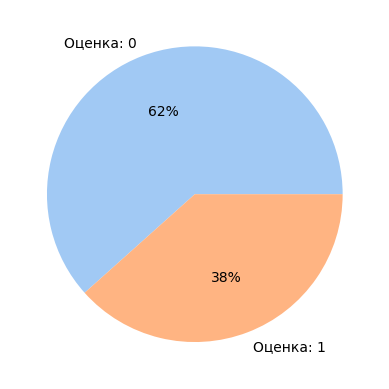

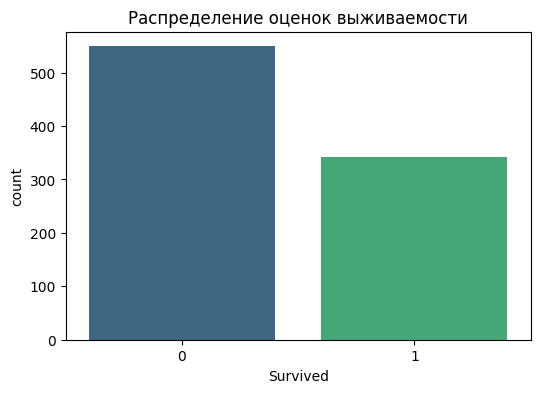

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

def draw_pie_plot(df: pd.DataFrame, column_name: str):
    explore_column = df[column_name]
    explore_column_normal = list(zip(
        [f'Оценка: {q}' for q in explore_column.value_counts().index],
        explore_column.value_counts(normalize=True)
    ))

    label, params = zip(*explore_column_normal)

    colors = sns.color_palette('pastel')[0:len(params)]
    plt.pie(params, labels=label, colors=colors, autopct='%.0f%%')
    plt.show()

def draw_bar_plot(df: pd.DataFrame, column_name: str, title: str):
    plt.figure(figsize=(6,4))
    sns.countplot(x=column_name, data=df, hue="Survived", palette="viridis", legend=False)
    plt.title(title)
    plt.show()


draw_pie_plot(df, 'Survived')
draw_bar_plot(df, 'Survived', title = "Распределение оценок выживаемости")

**Вывод:** целевая переменная является умеренно несбалансированной


Посмотрим на корреляцию данных.

***Определение 1: Корреляция данных — это статистическая мера, показывающая, насколько и в каком направлении связаны между собой две переменные.***

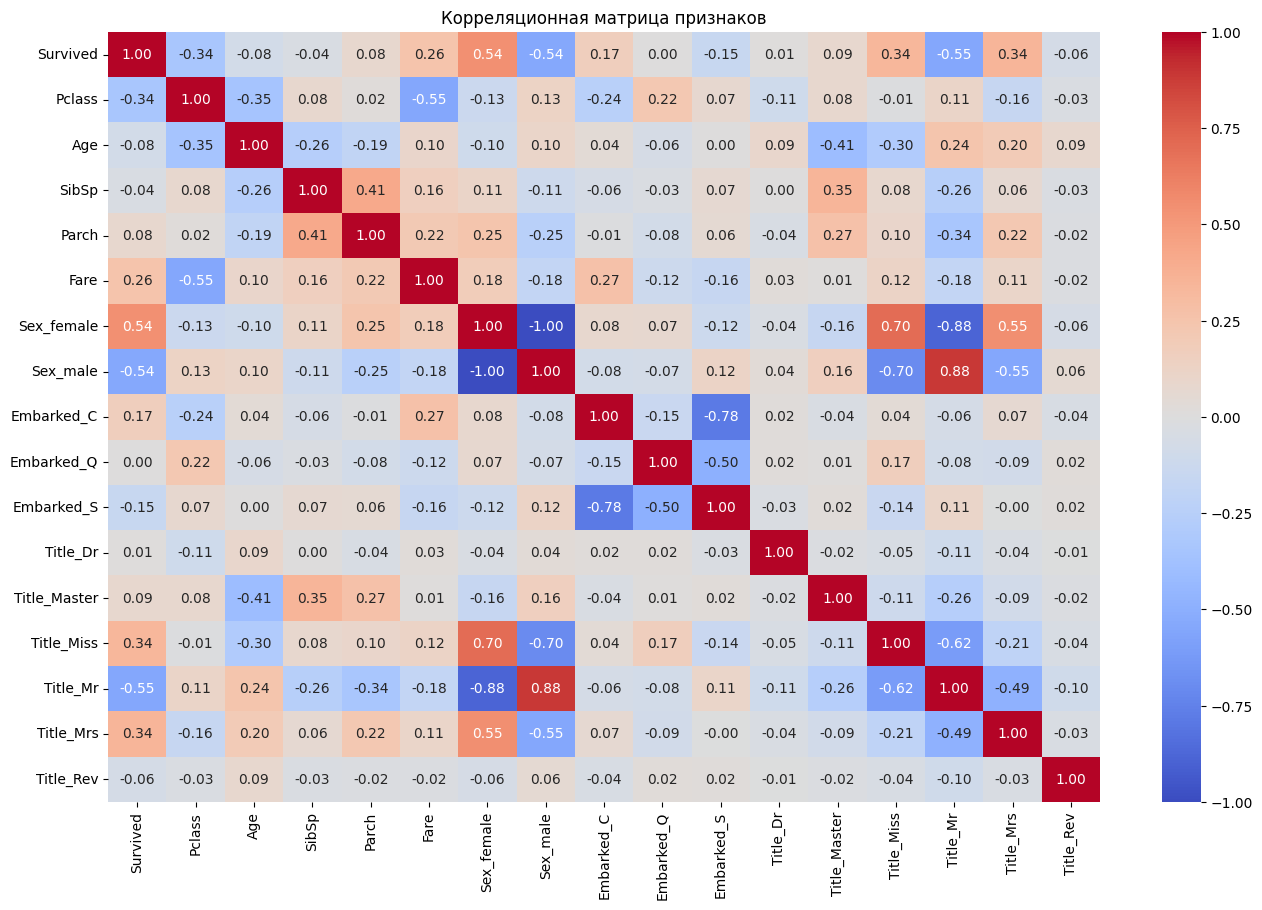

In [24]:
# @title Текст заголовка по умолчанию
def draw_corr_matrix(df):
    plt.figure(figsize=(16,10))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Корреляционная матрица признаков")
    plt.show()

draw_corr_matrix(df)

**!!! ВАЖНО !!!**

**ЕСЛИ МЫ СОБИРАЕМСЯ УЧИТЬ ЛИНЕЙНУЮ МОДЕЛЬ, И ДАННЫЕ КОРРЕЛИРУЮТ (МУЛЬТИКОЛЛИНЕАРНОСТЬ), ТО НУЖНО ЛИБО УДАЛИТЬ ОДИН ИЗ ПРИЗНАКОВ, ЛИБО СОЗДАТЬ НОВЫЙ ПРИЗНАК НА ИХ ОСНОВЕ И ИХ УДАЛИТЬ**

### 1.3. Подготовка датасета под разные задачи

Cравнение подготовки

| Модель                  | Масштабирование | Корреляция критична | Выбросы критичны | Feature Engineering рекомендуем                  |
| ----------------------- | --------------- | ------------------- | ---------------- | ------------------------------------------------ |
| Линейная регрессия      | Да              | Да                  | Да               | Полиномы, логарифмы, отношения                   |
| Random Forest Regressor | Нет             | Нет                 | Нет              | Соотношения, интеракции                          |
| XGBoost Regressor       | Нет             | Нет                 | Нет              | Соотношения, интеракции, логарифмы (опционально) |

#### 1.3.1 Линейная регрессия (Linear Regression / Ridge / Lasso)

**Особенности модели:**

- Чувствительна к масштабу признаков и мультиколлинеарности.
- Чувствительна к выбросам.

Сделаем копию датасета

In [25]:
df_linear = df.copy()

Рассмотрим скошенность данных

***Определение 2: Скошенность – это мера асимметрии распределения признака***

* **Скошенность > 0 (положительная):** Хвост распределения тянется вправо (большие значения встречаются реже).

* **Скошенность < 0 (отрицательная):** Хвост распределения тянется влево (малые значения редки).

* **Скошенность ≈ 0:** Практически нормальное распределение (симметричное).


Разделение датасета на признаки и целевую переменную

In [26]:
X_linear = df_linear.drop(columns=['Survived'])
y_linear = df_linear['Survived']

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def check_outliers(df, columns=None, title="", cols_per_row=3, cell_size=(8, 4)):
    """
    Анализ выбросов с выводом графиков в сетке

    Parameters:
    - df: DataFrame для анализа
    - columns: список колонок для анализа (по умолчанию все числовые)
    - title: заголовок для вывода
    - cols_per_row: количество графиков в строке
    - cell_size: размер одной ячейки сетки (width, height) в дюймах
    """
    if columns is None:
        columns = df.select_dtypes(include='number').columns

    # Если колонок нет, выходим из функции
    if len(columns) == 0:
        print("Нет числовых колонок для анализа")
        return

    # Рассчитываем количество строк для сетки
    n_cols = len(columns)
    n_rows = (n_cols + cols_per_row - 1) // cols_per_row

    # Рассчитываем общий размер фигуры на основе размера ячейки
    fig_width = cell_size[0] * cols_per_row
    fig_height = cell_size[1] * n_rows

    # Создаем основную фигуру
    fig, axes = plt.subplots(n_rows, cols_per_row,
                            figsize=(fig_width, fig_height))

    # Если только одна строка, преобразуем axes в 2D массив для единообразия
    if n_rows == 1:
        axes = np.array([axes]) if cols_per_row > 1 else np.array([[axes]])
    elif n_cols == 1:
        axes = np.array([[ax] for ax in axes])

    # Собираем статистику по выбросам
    outliers_stats = []

    for i, col in enumerate(columns):
        # Вычисляем выбросы
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_count = len(outliers)
        outliers_percent = (outliers_count / len(df)) * 100

        # Сохраняем статистику
        outliers_stats.append({
            'column': col,
            'count': outliers_count,
            'percent': outliers_percent,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR
        })

        # Определяем позицию в сетке
        row_idx = i // cols_per_row
        col_idx = i % cols_per_row

        # Строим boxplot
        ax = axes[row_idx, col_idx]
        sns.boxplot(x=df[col], ax=ax)

        # Настраиваем заголовок и метки
        ax.set_title(f"{col}\nВыбросы: {outliers_count} ({outliers_percent:.1f}%)",
                    fontsize=10, fontweight='bold')
        ax.set_xlabel("")

        # Добавляем вертикальные линии для границ выбросов
        ax.axvline(x=lower_bound, color='red', linestyle='--', alpha=0.7, linewidth=1)
        ax.axvline(x=upper_bound, color='red', linestyle='--', alpha=0.7, linewidth=1)

        # Добавляем аннотации с границами
        ax.text(0.02, 0.98, f"Границы: [{lower_bound:.2f}, {upper_bound:.2f}]",
               transform=ax.transAxes, verticalalignment='top', fontsize=8,
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # Добавляем информацию о квантилях
        ax.text(0.02, 0.85, f"Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}",
               transform=ax.transAxes, verticalalignment='top', fontsize=7,
               bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

    # Скрываем пустые subplots
    for i in range(len(columns), n_rows * cols_per_row):
        row_idx = i // cols_per_row
        col_idx = i % cols_per_row
        axes[row_idx, col_idx].set_visible(False)

    # Общий заголовок
    if title:
        fig.suptitle(f"Анализ выбросов: {title}", fontsize=14, fontweight='bold', y=0.98)
    else:
        fig.suptitle("Анализ выбросов", fontsize=14, fontweight='bold', y=0.98)

    plt.tight_layout()
    plt.show()

    return outliers_stats


In [28]:
from sklearn.model_selection import train_test_split

skew_values_x_linear = X_linear.skew()
skew_values_hard = skew_values_x_linear[abs(skew_values_x_linear) > 0.5]
print(skew_values_hard)

skew_columns_hard = list(skew_values_hard.index)
print(f'СКОШЕННЫЕ СТОЛБЦЫ СВОЙСТВ: {skew_columns_hard}')

y_skew = y_linear.skew()
print(f'\nСКОШЕННОСТЬ целевой переменной (Survived): {y_skew:.4f}')
if abs(y_skew) > 0.5:
    print("Целевая переменная сильно скошена!")
else:
    print("Целевая переменная не сильно скошена!")

# Разделение выборки на test/train (20/80)
X_linear_train, X_linear_test, y_linear_train, y_linear_test = train_test_split(
    X_linear, y_linear, test_size=0.2, random_state=RND_SEED
)

Pclass          -0.630548
SibSp            3.695352
Parch            2.749117
Fare             4.787317
Sex_female       0.618921
Sex_male        -0.618921
Embarked_C       1.595149
Embarked_Q       2.948778
Embarked_S      -1.009665
Title_Dr        11.167515
Title_Master     4.403096
Title_Miss       1.435649
Title_Mrs        2.048439
Title_Rev       12.082970
dtype: float64
СКОШЕННЫЕ СТОЛБЦЫ СВОЙСТВ: ['Pclass', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Dr', 'Title_Master', 'Title_Miss', 'Title_Mrs', 'Title_Rev']

СКОШЕННОСТЬ целевой переменной (Survived): 0.4785
Целевая переменная не сильно скошена!


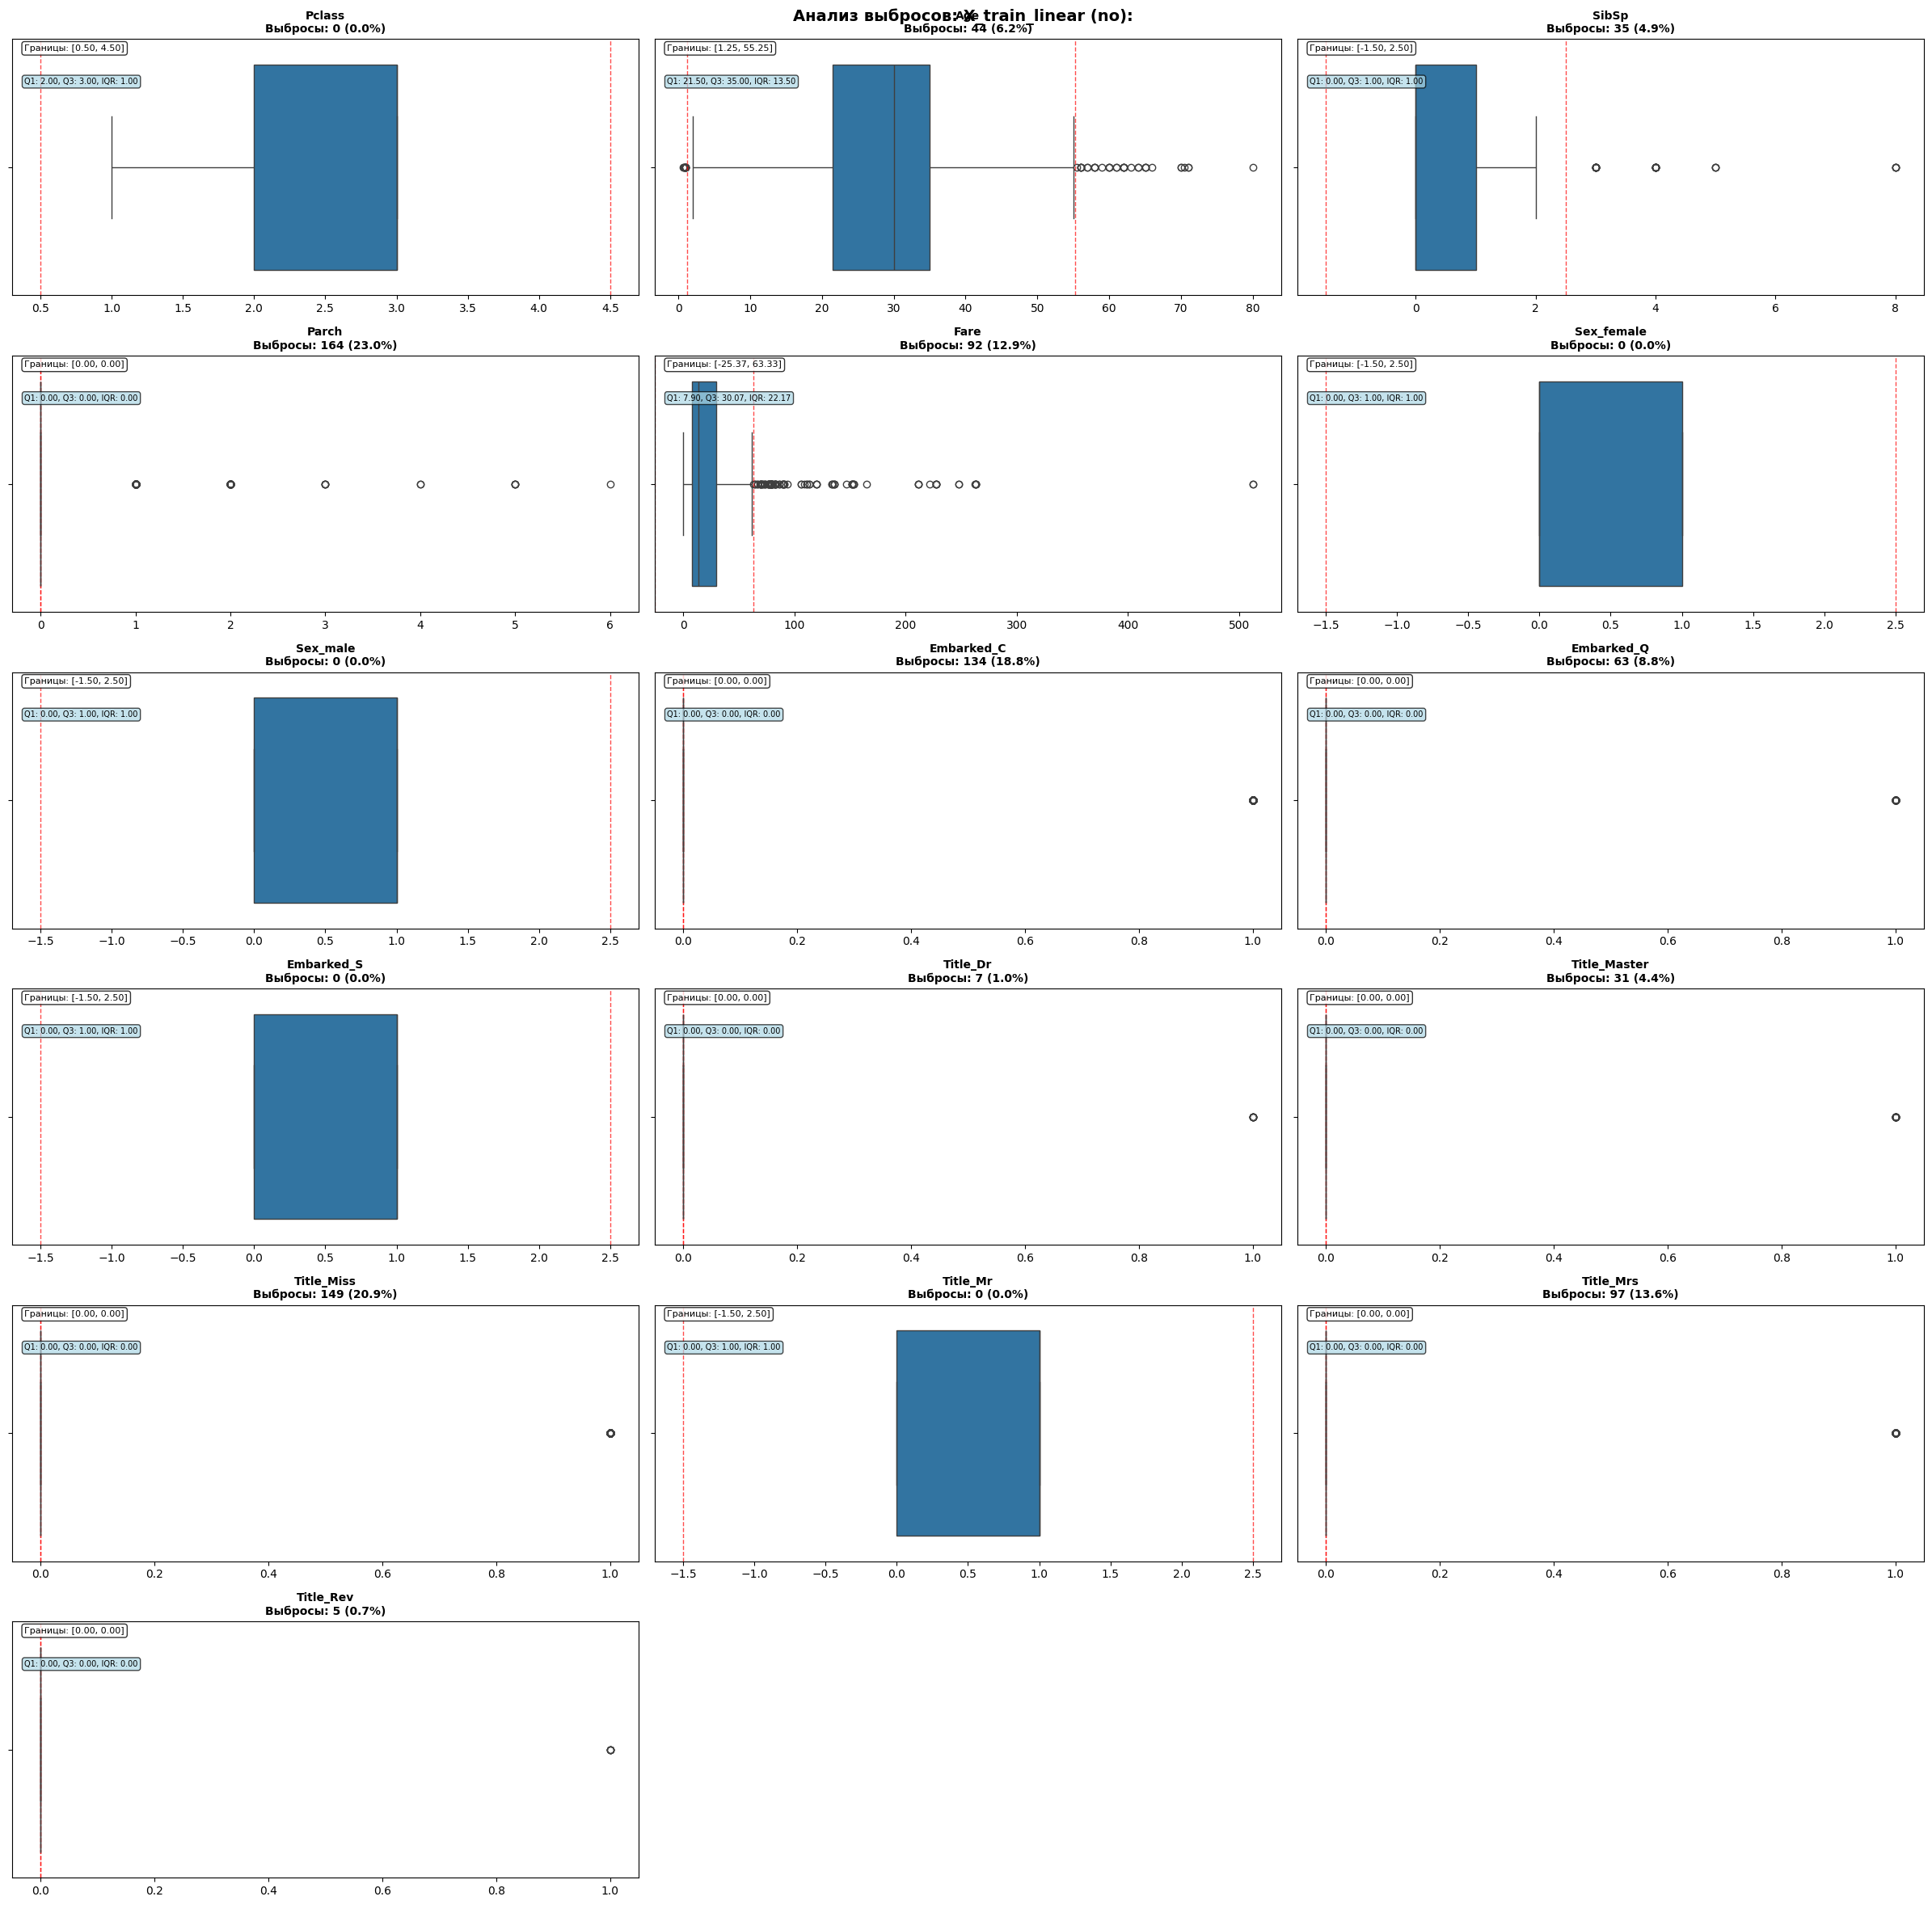

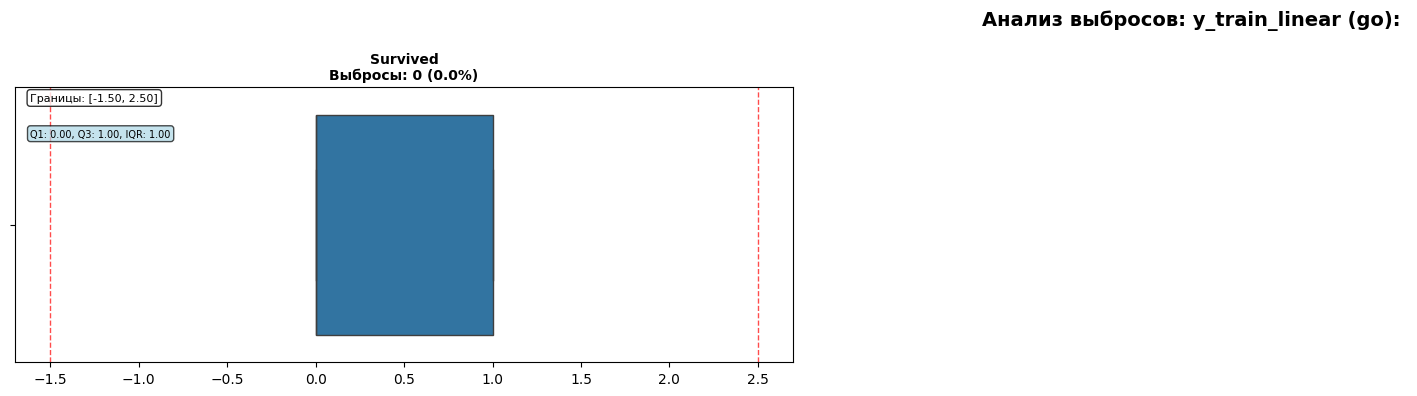

[{'column': 'Survived',
  'count': 0,
  'percent': 0.0,
  'lower_bound': np.float64(-1.5),
  'upper_bound': np.float64(2.5),
  'Q1': np.float64(0.0),
  'Q3': np.float64(1.0),
  'IQR': np.float64(1.0)}]

In [29]:
check_outliers(X_linear_train, title="X_train_linear (no): ")

check_outliers(pd.DataFrame(y_linear_train, columns=['Survived']), title="y_train_linear (go): ")

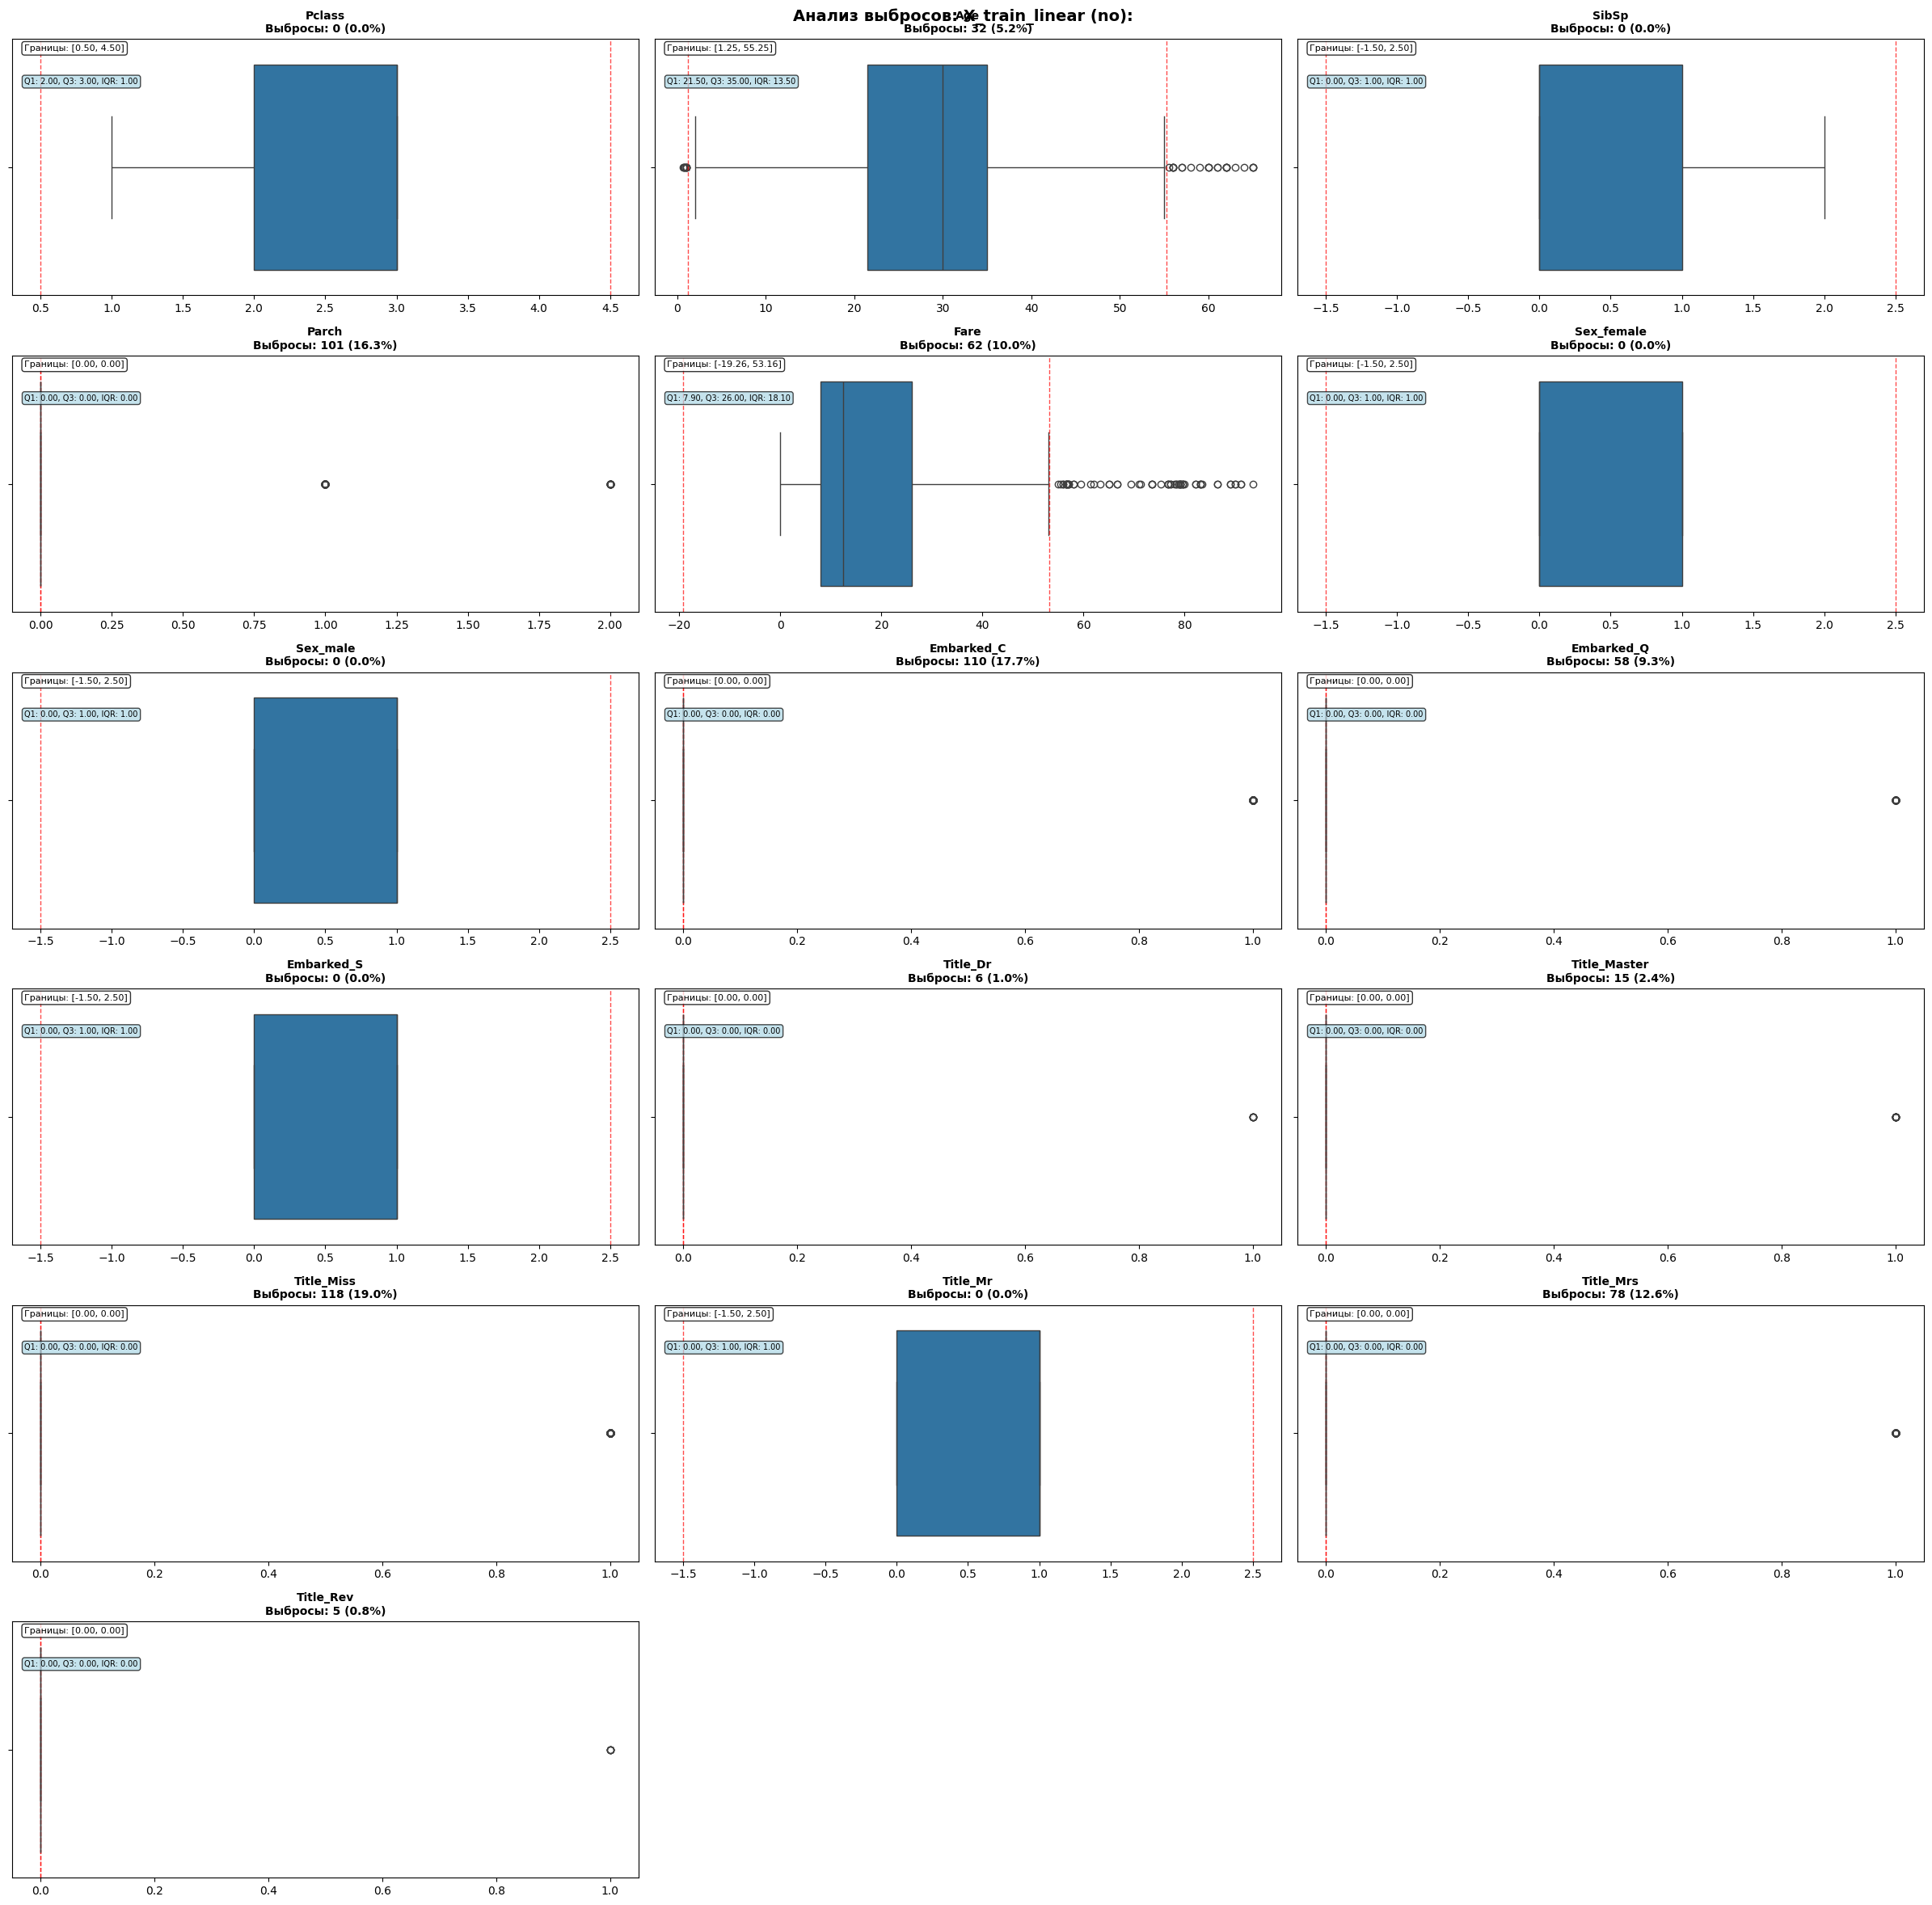

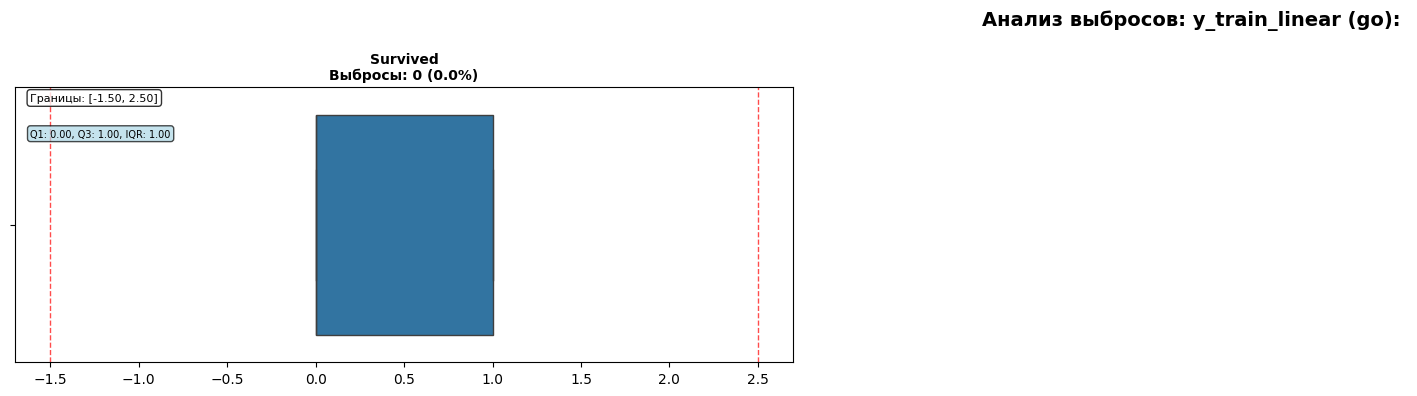

[{'column': 'Survived',
  'count': 0,
  'percent': 0.0,
  'lower_bound': np.float64(-1.5),
  'upper_bound': np.float64(2.5),
  'Q1': np.float64(0.0),
  'Q3': np.float64(1.0),
  'IQR': np.float64(1.0)}]

In [30]:
mask = ((X_linear_train["Fare"] <= 100) & (X_linear_train["Parch"] <= 2)) & ((X_linear_train["SibSp"] <= 2) & (X_linear_train["Age"] <= 65))

X_linear_train = X_linear_train.loc[mask]
y_linear_train = y_linear_train.loc[mask]

# print(mask)

check_outliers(X_linear_train, title="X_train_linear (no): ")

check_outliers(pd.DataFrame(y_linear_train, columns=['Survived']), title="y_train_linear (go): ")

In [31]:
skew_values = df_linear.skew()
skew_values_hard = skew_values[abs(skew_values) > 0.5]  # выделяем сильноскошенные данные
print(skew_values_hard)  # сильно скошенные

skew_columns_hard = list(skew_values_hard.index)
print(f'Скошенные столбцы {skew_columns_hard}')

Pclass          -0.630548
SibSp            3.695352
Parch            2.749117
Fare             4.787317
Sex_female       0.618921
Sex_male        -0.618921
Embarked_C       1.595149
Embarked_Q       2.948778
Embarked_S      -1.009665
Title_Dr        11.167515
Title_Master     4.403096
Title_Miss       1.435649
Title_Mrs        2.048439
Title_Rev       12.082970
dtype: float64
Скошенные столбцы ['Pclass', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Dr', 'Title_Master', 'Title_Miss', 'Title_Mrs', 'Title_Rev']


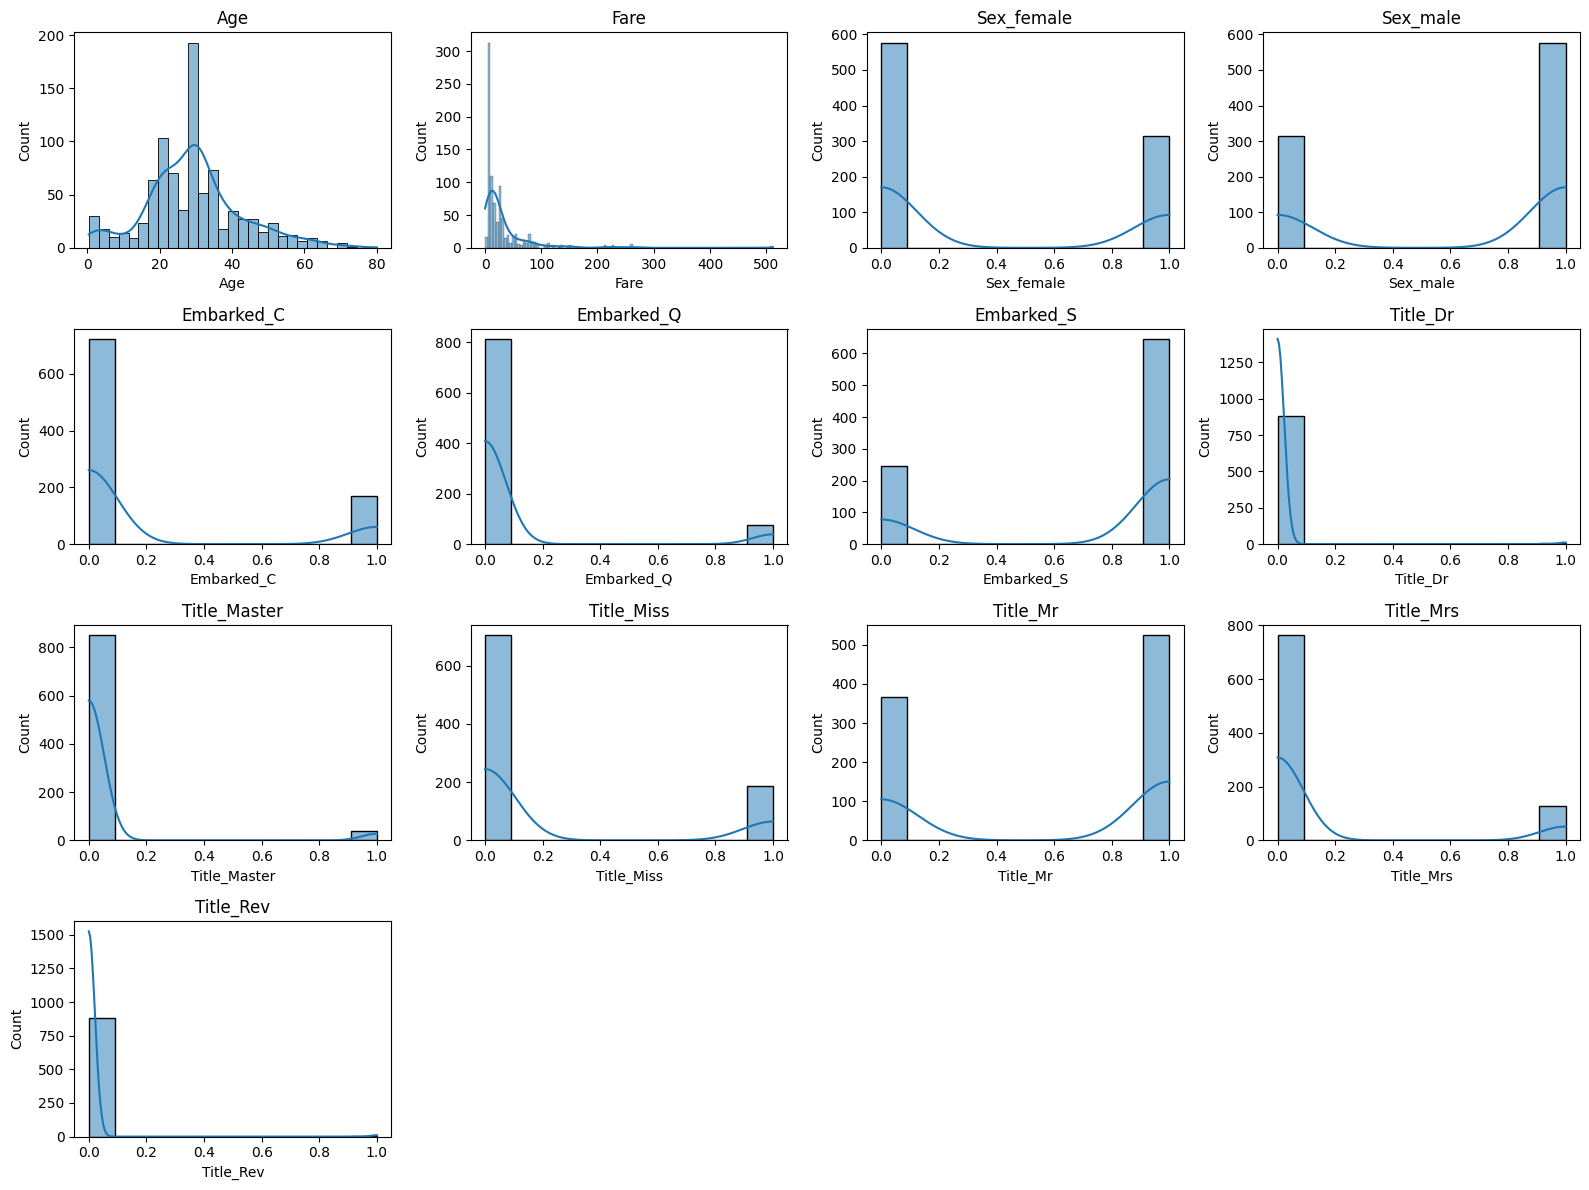

In [32]:
import math

def draw_skew(df: pd.DataFrame, n_cols=4):
    float_cols = df.select_dtypes(include='float').columns
    n_rows = math.ceil(len(float_cols) / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    axs = axs.flatten()  # делаем одномерным массивом для удобства

    for i, col in enumerate(float_cols):
        sns.histplot(df[col], kde=True, ax=axs[i])
        axs[i].set_title(f'{col}')

    # Если графиков меньше, чем ячеек в сетке, скрываем лишние
    for j in range(i+1, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    plt.show()


draw_skew(df_linear)

Можно уменьшить влияние скошенности с помошью:

- Логарифмирование (Уменьшаем положительный хвост)
- Квадратный корень  (сглаживаем умеренные хвосты)
- `Box-Cox` или `Yeo-Johnson` трансформации (более гибкие)

Мы же просто прологарифмируем :)

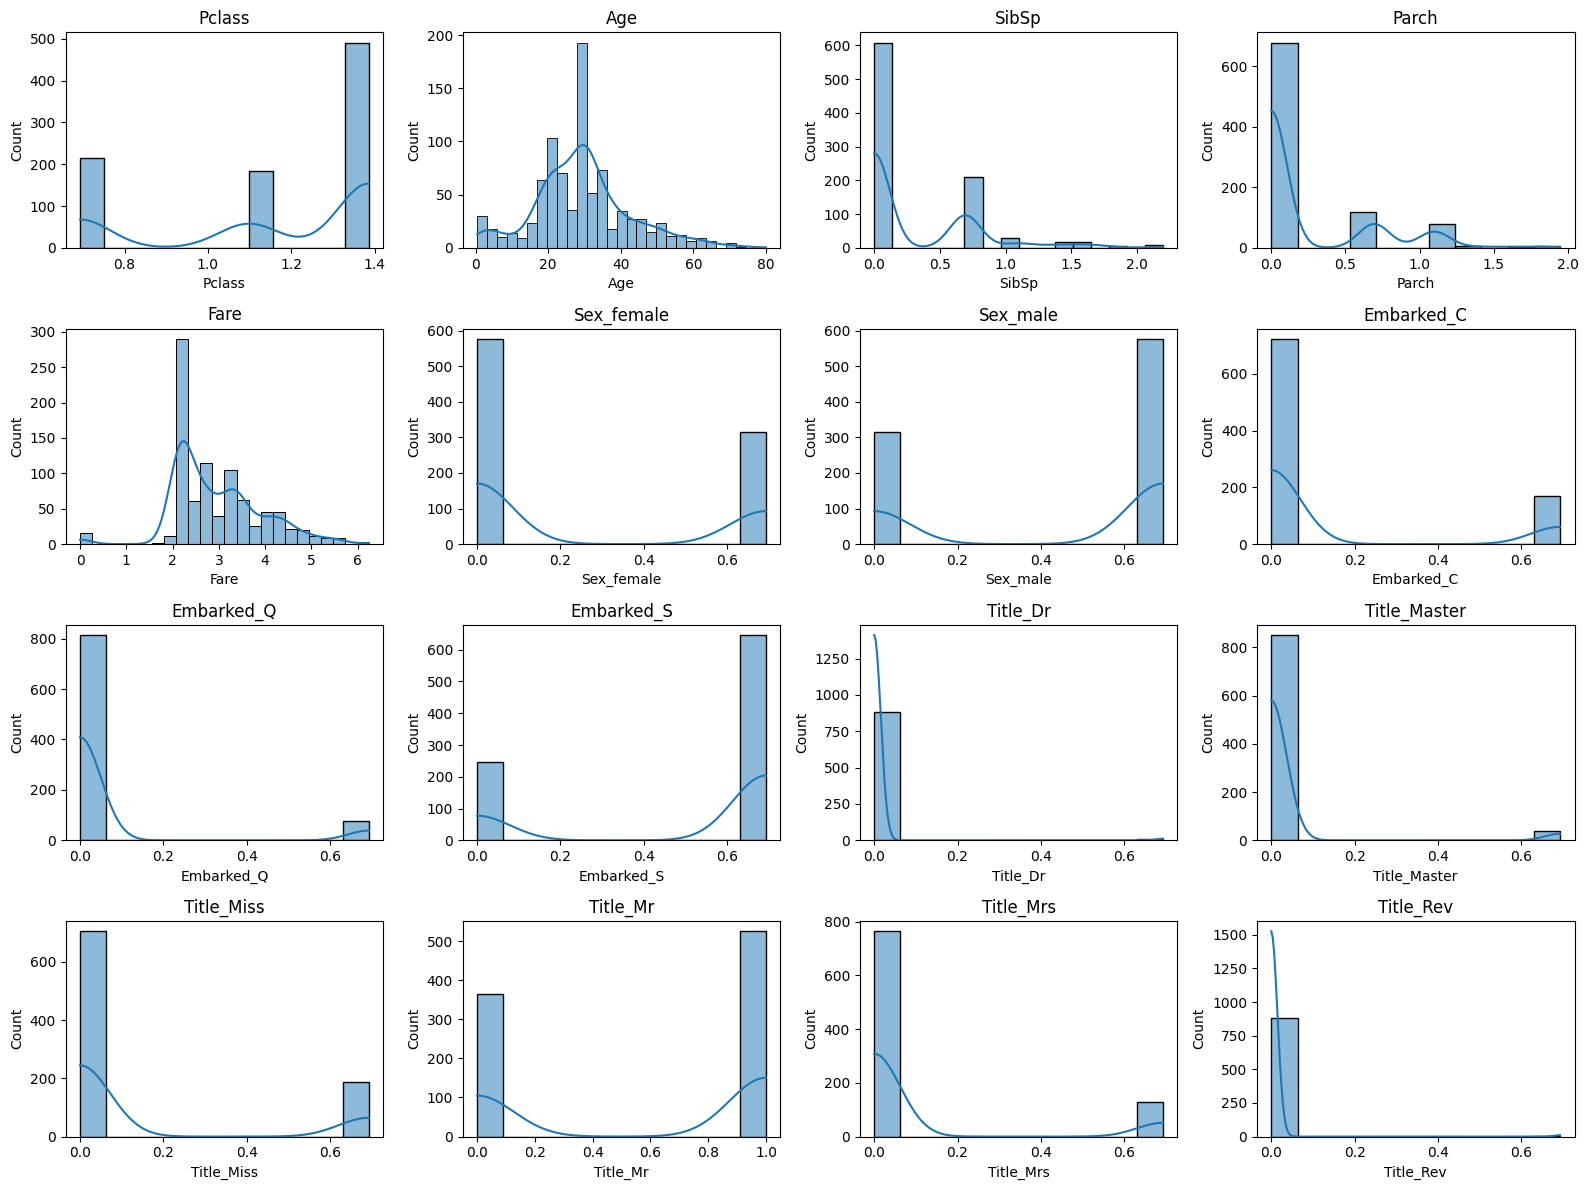

In [33]:
def prepare_skew(df: pd.DataFrame, columns: list[str]):
    for col in columns:
        df[col] = np.log1p(df[col])
    return df

df_linear = prepare_skew(df = df_linear, columns = skew_columns_hard)

draw_skew(df_linear)

Сделаем `Feature Engineering`



In [34]:
# Полиномиальные признаки
if not USE_AUTO_POLY:
    # Ручное создание признаков
    df_linear['fare_log'] = np.log(df_linear['Fare'] + 1)
    df_linear['family_size'] = df_linear['SibSp'] + df_linear['Parch'] + 1
    df_linear['age_class_interaction'] = df_linear['Age'] * df_linear['Pclass']
    df_linear['fare_per_person'] = df_linear['Fare'] / np.where(df_linear['family_size'] > 0, df_linear['family_size'], 1)

    fare_pp_median = df_linear['fare_per_person'].replace([np.inf, -np.inf], np.nan).median()
    df_linear['fare_per_person'] = df_linear['fare_per_person'].fillna(fare_pp_median)

    df_linear['is_alone'] = (df_linear['family_size'] == 1).astype(int)
    df_linear['pclass_fare_interaction'] = df_linear['Pclass'] * df_linear['Fare']

else:
    from sklearn.preprocessing import PolynomialFeatures

    # Выбираем только числовые признаки для полиномиальных преобразований
    num_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_int', 'Embarked_int']

    # Убедимся, что Survived не входит в фичи для полиномирования
    X_num = df[num_features]

    # Создаём генератор полиномиальных признаков (degree=2)
    poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
    X_poly = poly.fit_transform(X_num)

    # Получаем имена новых признаков
    feature_names = poly.get_feature_names_out(num_features)

    # Превращаем обратно в DataFrame
    df_poly = pd.DataFrame(X_poly, columns=feature_names, index=df.index)

    # Объединяем с исходным DataFrame
    df = pd.concat([df, df_poly], axis=1)


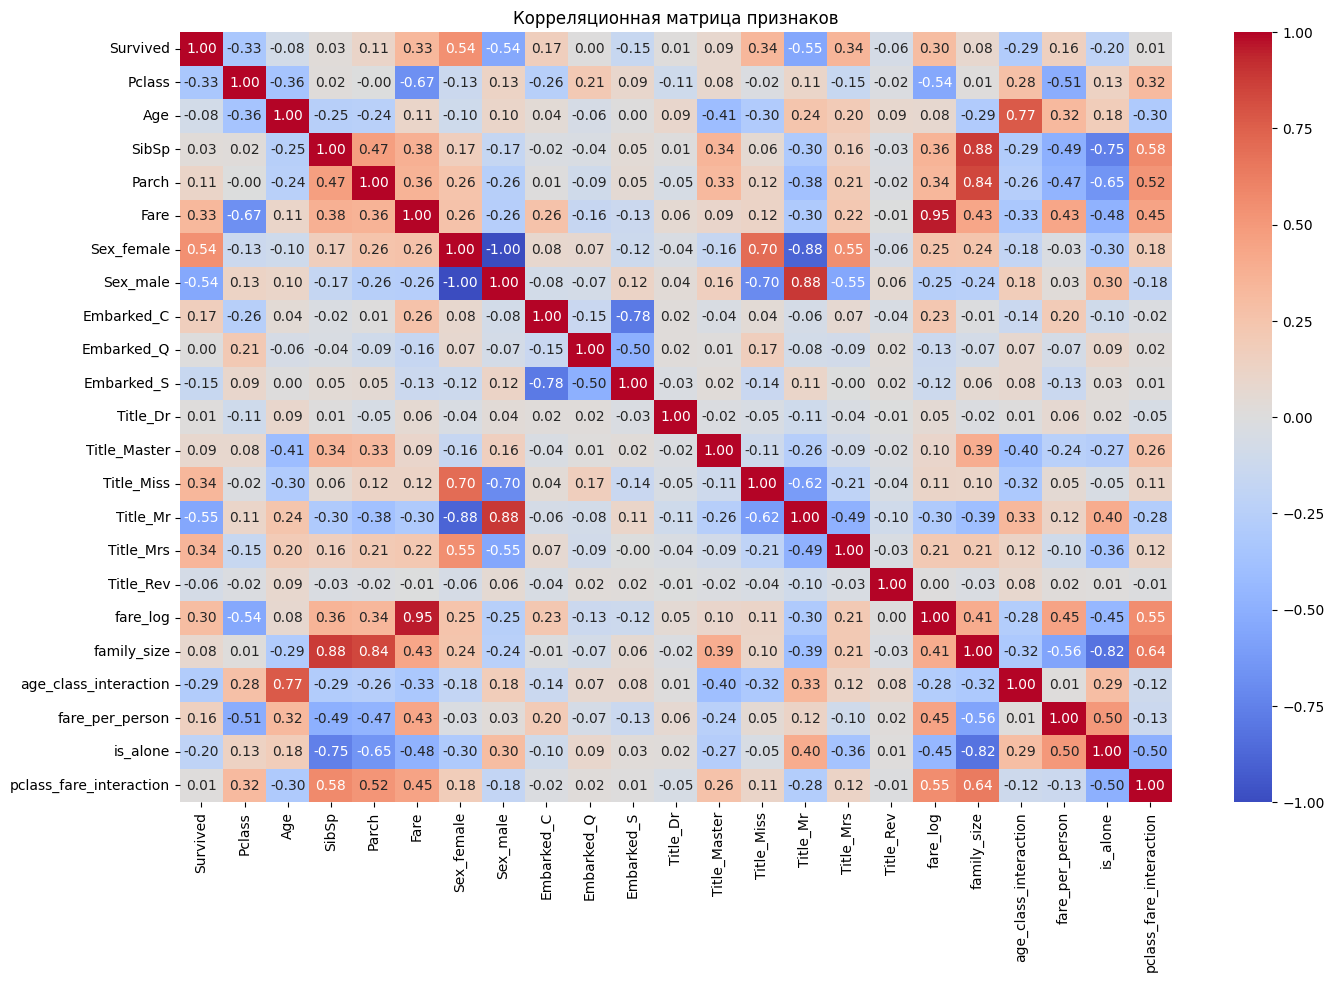

In [35]:
if not USE_AUTO_POLY:
    draw_corr_matrix(df_linear)
else:
    print(df_linear.corr())

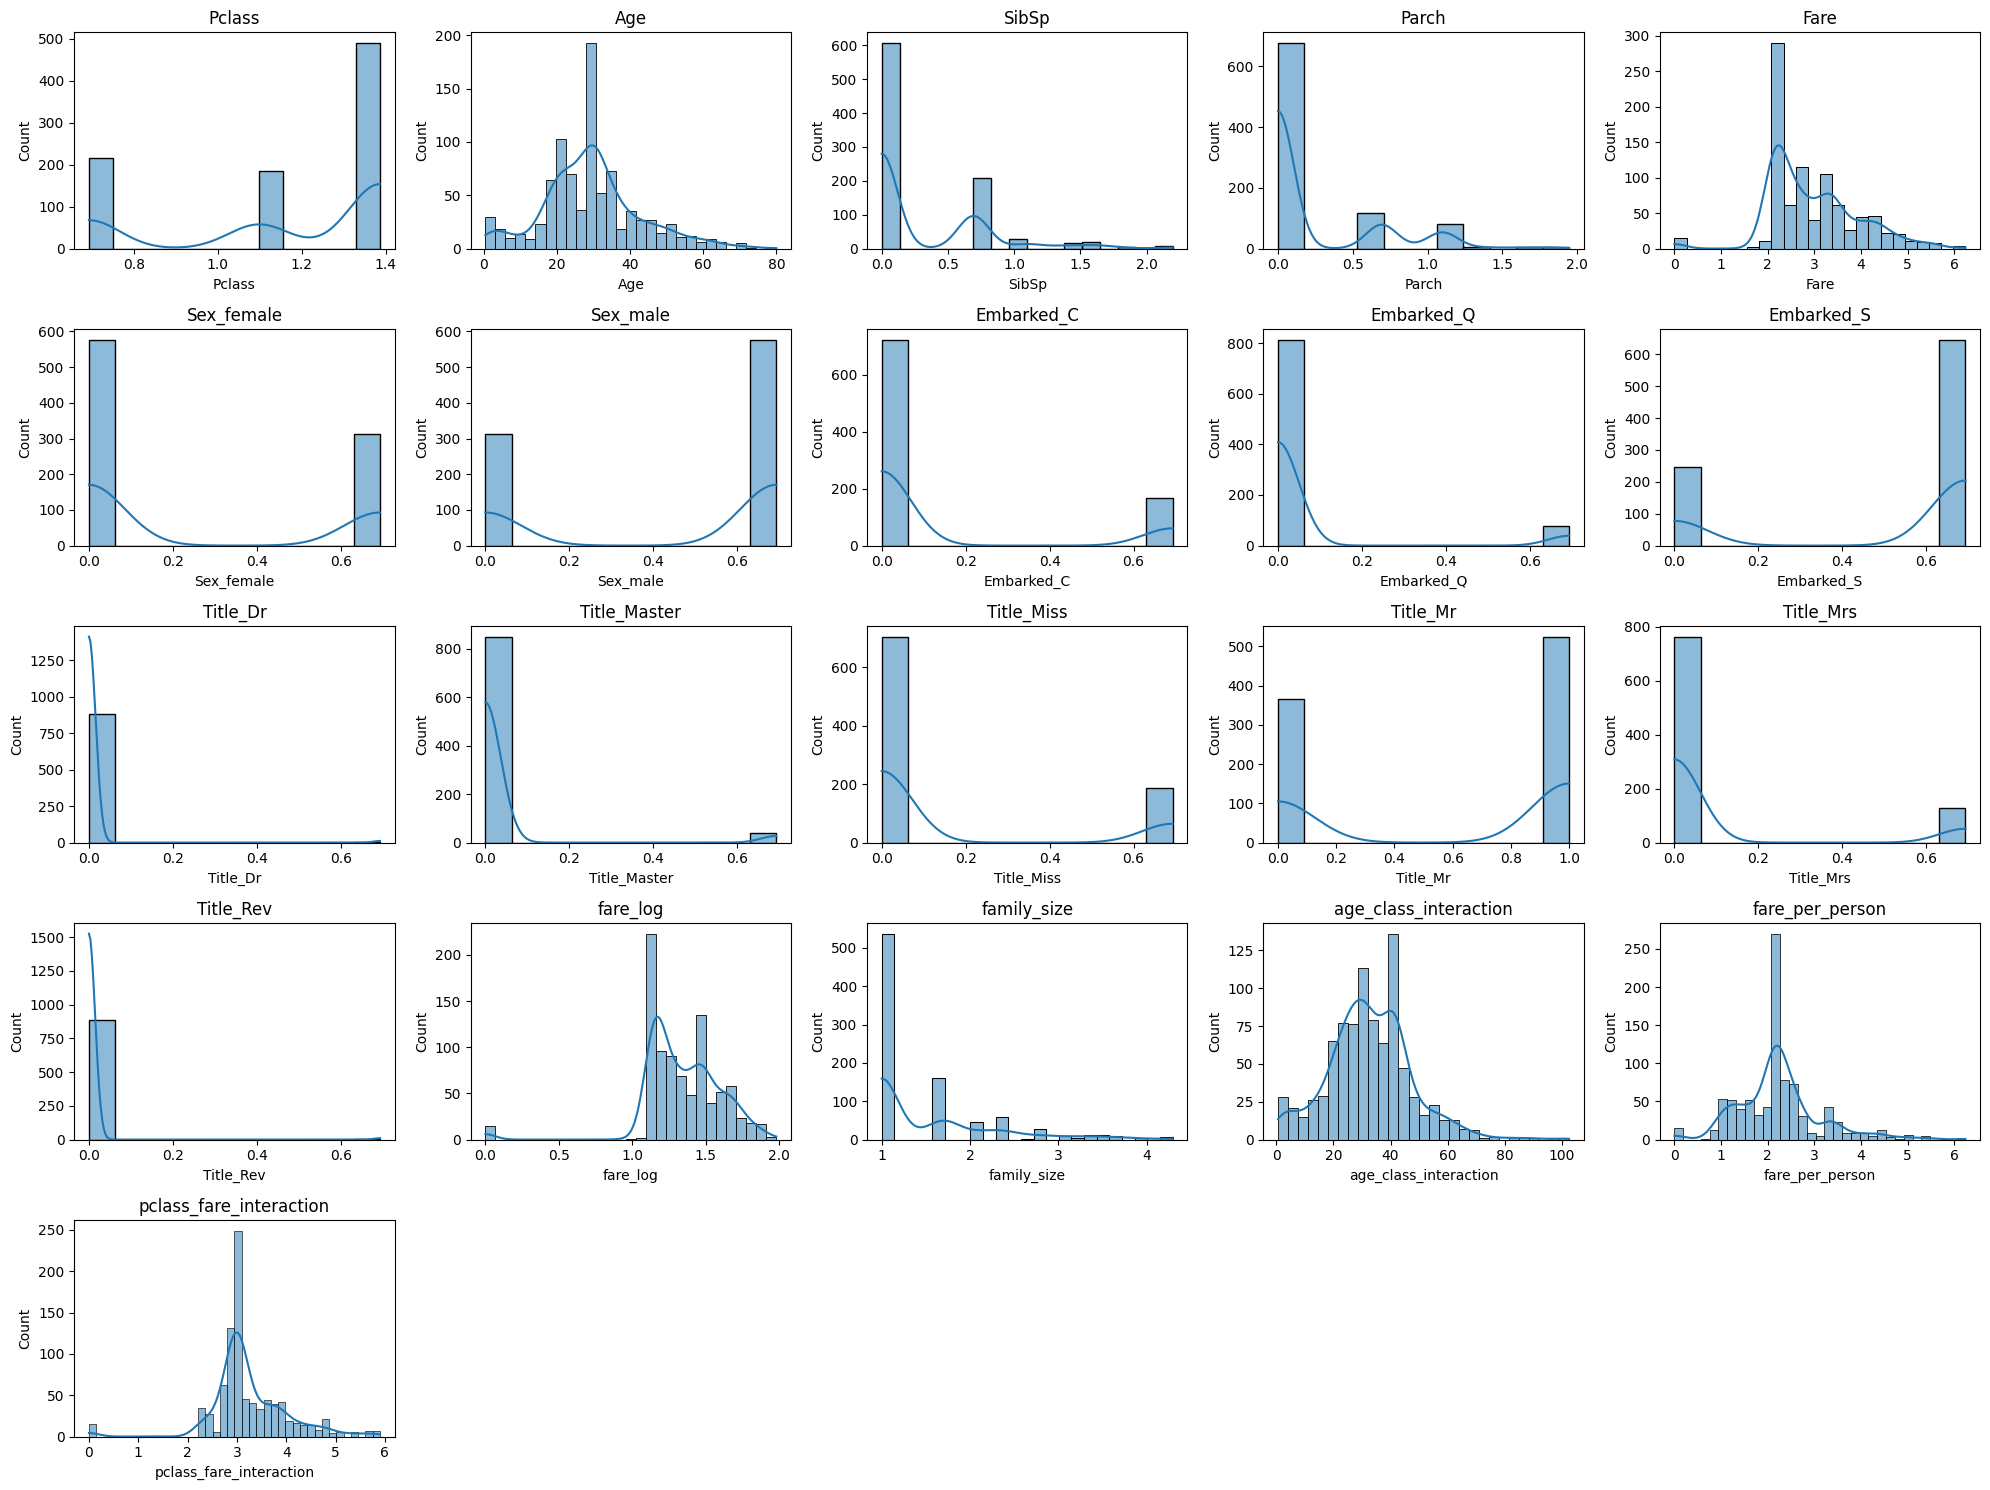

In [36]:
if not USE_AUTO_POLY:
    draw_skew(df_linear, 5)

Данные для обучения модели нужно стандартизировать

***Определение 4: Стандартизация признаков — это метод преобразования числовых признаков так, чтобы они имели среднее значение 0 и стандартное отклонение 1. Это важный шаг в подготовке данных для моделей, чувствительных к масштабу признаков, например линейной регрессии, логистической регрессии, SVM, KNN.***

**Как это работает**

Для каждого признака $x$ вычисляется:

$$
x_\text{scaled} = \frac{x - \mu}{\sigma}
$$

где:

* $\mu$ — среднее значение признака в обучающей выборке,
* $\sigma$ — стандартное отклонение признака.

После стандартизации:

* Среднее значение нового признака ≈ 0
* Стандартное отклонение ≈ 1


In [37]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_linear_scaled = scaler.fit_transform(X_linear_train)  # вычисляет среднее и стандартное отклонение (только на train)
X_test_linear_scaled = scaler.transform(X_linear_test)  # применяет эти параметры к любым данным (train, test, новые данные)

#### 1.3.2 Random Forest Regressor

**Особенности модели:**

* Не чувствительна к масштабу признаков.
* Может обрабатывать сильные корреляции между признаками.
* Может использовать категориальные признаки, если они закодированы как числовые.


Сделаем копию датасета

In [38]:
df_forest = df.copy()

Feature engineering

In [39]:
df_forest['fare_log'] = np.log(df_forest['Fare'] + 1)
df_forest['family_size'] = df_forest['SibSp'] + df_forest['Parch'] + 1
df_forest['age_class_interaction'] = df_forest['Age'] * df_forest['Pclass']
df_forest['fare_per_person'] = df_forest['Fare'] / np.where(df_forest['family_size'] > 0, df_forest['family_size'], 1)
fare_pp_median = df_forest['fare_per_person'].replace([np.inf, -np.inf], np.nan).median()
df_forest['fare_per_person'] = df_forest['fare_per_person'].fillna(fare_pp_median)
df_forest['is_alone'] = (df_forest['family_size'] == 1).astype(int)
df_forest['pclass_fare_interaction'] = df_forest['Pclass'] * df_forest['Fare']

Разделение выборки

In [40]:
X_forest = df_forest.drop(columns=['Survived'])
y_forest = df_forest['Survived']

X_train_forest, X_test_forest, y_train_forest, y_test_forest = train_test_split(
    X_forest, y_forest, test_size=0.2, random_state=RND_SEED
)

#### 1.3.3 XGBoost

**Особенности модели:**

* Градиентный бустинг деревьев.
* Не чувствителен к масштабу.
* Может обрабатывать коррелированные признаки, но слишком много слабых признаков может замедлить обучение.

Сделаем копию датасета

In [41]:
df_xgboost = df.copy()

Feature engineering

In [42]:
df_xgboost['fare_log'] = np.log(df_xgboost['Fare'] + 1)
df_xgboost['family_size'] = df_xgboost['SibSp'] + df_xgboost['Parch'] + 1
df_xgboost['age_class_interaction'] = df_xgboost['Age'] * df_xgboost['Pclass']
df_xgboost['fare_per_person'] = df_xgboost['Fare'] / np.where(df_xgboost['family_size'] > 0, df_xgboost['family_size'], 1)
fare_pp_median = df_xgboost['fare_per_person'].replace([np.inf, -np.inf], np.nan).median()
df_xgboost['fare_per_person'] = df_xgboost['fare_per_person'].fillna(fare_pp_median)
df_xgboost['is_alone'] = (df_xgboost['family_size'] == 1).astype(int)
df_xgboost['pclass_fare_interaction'] = df_xgboost['Pclass'] * df_xgboost['Fare']

In [43]:
# Преобразуем все данные в числовые типы
df_xgboost = df_xgboost.apply(pd.to_numeric, errors='coerce')
df_xgboost = df_xgboost.fillna(0)

Разделение выборки

In [44]:
X_xgboost = df_xgboost.drop(columns=['Survived'])
y_xgboost = df_xgboost['Survived']

X_train_xgboost, X_test_xgboost, y_train_xgboost, y_test_xgboost = train_test_split(
    X_xgboost, y_xgboost, test_size=0.2, random_state=RND_SEED
)

## 2. Создание метрик

1. **MSE (Mean Squared Error)** – средняя квадратичная ошибка:

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

* Чем меньше, тем лучше.
* Чувствительна к выбросам (квадрат ошибки усиливает влияние больших отклонений).

2. **RMSE (Root Mean Squared Error)** – корень из MSE:

$$
\text{RMSE} = \sqrt{\text{MSE}}
$$

* В тех же единицах, что и целевая переменная.
* Легче интерпретировать.

3. **MAE (Mean Absolute Error)** – средняя абсолютная ошибка:

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

* Менее чувствительна к выбросам, показывает «среднюю ошибку» в исходных единицах.

4. **R² (коэффициент детерминации)**:

$$
R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}
$$

* 1 → идеальное предсказание, 0 → модель не лучше среднего, <0 → хуже среднего.

**Как интерпретировать**

| Метрика | Как читать                    | Что значит для анализа                                                   |
| ------- | ----------------------------- | ------------------------------------------------------------------------ |
| MSE     | Чем меньше, тем точнее        | Показывает среднюю квадратичную ошибку. Выбросы сильно влияют.           |
| RMSE    | В тех же единицах, что и цель | Удобно для прямой интерпретации ошибок.                                  |
| MAE     | Средняя абсолютная ошибка     | Устойчивее к выбросам, показывает среднюю фактическую ошибку.            |
| R²      | 0–1 (или <0)                  | 1 — идеальное совпадение, 0 — предсказывает среднее, <0 — хуже среднего. |

**Пример анализа:**

* Если RMSE и MAE сильно отличаются → есть выбросы.
* Если R² близок к 1 → модель хорошо объясняет вариацию данных.
* Можно сравнивать модели: линейная, RF, XGBoost. Та, у которой меньше RMSE/MAE и выше R² — более точная.


In [45]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def r2(y_true, y_pred):
    return 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))

def get_metrics(y_true, y_pred):
    return {
        'MSE': mse(y_true, y_pred),
        'RMSE': rmse(y_true, y_pred),
        'MAE': mae(y_true, y_pred),
        'R2': r2(y_true, y_pred)
    }


Прежде чем начнем обучать, создадим `DataFrame` для снятия метрик

In [46]:
metrics_df = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE', 'R²'])

metrics_df.head()

,Model,MSE,RMSE,MAE,R²


## 3. Базовая модель линейной регрессии (аналитическое решение)

In [47]:
# Создание линейной модели
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [48]:
# Обучение
lr.fit(X_train_linear_scaled, y_linear_train)

LinearRegression()

In [49]:
# Прогонка и метрики
y_pred = lr.predict(X_test_linear_scaled)
lr_metrics = get_metrics(y_linear_test, y_pred)
lr_metrics

{'MSE': np.float64(0.14401385896136304),
 'RMSE': np.float64(0.3794915795658226),
 'MAE': np.float64(0.2837459132532481),
 'R2': np.float64(0.4061328114567525)}

## 4. Улучшенная версия линейной регрессии

In [50]:
from sklearn.linear_model import SGDRegressor

### 4.1. Градиентный спуск (симуляция)

In [51]:
# Создание линейной модели градиентного спуска
lr_gd = SGDRegressor(
    max_iter=2000,               # максимум итераций
    tol=1e-6,                    # остановка, когда улучшение < tol
    learning_rate='constant',  # тип изменения шага
    eta0=0.01,                   # стартовый шаг
    penalty='l2',                # регуляризация L2 (Ridge)
    shuffle=False,               # важный момент: не перемешиваем данные, чтобы был настоящий GD
    random_state=RND_SEED
)

In [52]:
# Обучение
lr_gd.fit(X_train_linear_scaled, y_linear_train)

SGDRegressor(learning_rate='constant', max_iter=2000, random_state=21,
             shuffle=False, tol=1e-06)

In [53]:
# Прогонка и метрики
y_pred = lr_gd.predict(X_test_linear_scaled)
lr_gd_metrics = get_metrics(y_linear_test, y_pred)
lr_gd_metrics

{'MSE': np.float64(0.15544258314681642),
 'RMSE': np.float64(0.3942620741928095),
 'MAE': np.float64(0.31513190892596704),
 'R2': np.float64(0.35900440069406114)}

### 4.2. Стохастический градиентный спуск

In [54]:
# Инициализация модели
lr_sgd = SGDRegressor(
    max_iter=2000,                # максимум итераций
    tol=1e-6,                     # остановка, когда улучшение < tol
    learning_rate='invscaling',   # тип изменения шага
    eta0=0.01,                    # стартовый шаг
    penalty='l1',                 # регуляризация L2 (Ridge)
    random_state=RND_SEED
)

In [55]:
# Обучение
lr_sgd.fit(X_train_linear_scaled, y_linear_train)

SGDRegressor(max_iter=2000, penalty='l1', random_state=21, tol=1e-06)

In [56]:
# Прогонка и метрики
y_pred = lr_sgd.predict(X_test_linear_scaled)
lr_sgd_metrics = get_metrics(y_linear_test, y_pred)
lr_sgd_metrics

{'MSE': np.float64(0.14110917028707134),
 'RMSE': np.float64(0.3756450056730042),
 'MAE': np.float64(0.28468565062904616),
 'R2': np.float64(0.4181108204416921)}

### 4.3. Линейная модель с регуляризацией Rigde (L2)

In [57]:
# Инициализация модели
from sklearn.linear_model import Ridge
lr_ridge = Ridge(alpha=1.0)

In [58]:
# Обучение
lr_ridge.fit(X_train_linear_scaled, y_linear_train)

Ridge()

In [59]:
# Прогонка и метрики
y_pred = lr_ridge.predict(X_test_linear_scaled)
lr_ridge_metrics = get_metrics(y_linear_test, y_pred)
lr_ridge_metrics

{'MSE': np.float64(0.14382393963446855),
 'RMSE': np.float64(0.37924126836944916),
 'MAE': np.float64(0.28353619834637256),
 'R2': np.float64(0.40691597814311375)}

### 4.3. Линейная модель с регуляризацией Lasso (L1)

In [60]:
# Инициализация модели
from sklearn.linear_model import Lasso
lr_lasso = Lasso(alpha=0.01)

In [61]:
# Обучение
lr_lasso.fit(X_train_linear_scaled, y_linear_train)

Lasso(alpha=0.01)

In [62]:
# Прогонка и метрики
y_pred = lr_lasso.predict(X_test_linear_scaled)
lr_lasso_metrics = get_metrics(y_linear_test, y_pred)
lr_lasso_metrics

{'MSE': np.float64(0.1460788190048525),
 'RMSE': np.float64(0.38220258895623993),
 'MAE': np.float64(0.28779100002025243),
 'R2': np.float64(0.39761757532374786)}

### 4.4. Линейная модель с регуляризацией ElasticNet (комбинация L1+L2)

In [63]:
# Инициализация модели
from sklearn.linear_model import ElasticNet
lr_enet = ElasticNet(alpha=0.01, l1_ratio=0.5)

In [64]:
# Обучение
lr_enet.fit(X_train_linear_scaled, y_linear_train)

ElasticNet(alpha=0.01)

In [65]:
# Прогонка и метрики
y_pred = lr_enet.predict(X_test_linear_scaled)
lr_enet_metrics = get_metrics(y_linear_test, y_pred)
lr_enet_metrics

{'MSE': np.float64(0.14395040486670907),
 'RMSE': np.float64(0.3794079662667998),
 'MAE': np.float64(0.2839359382885833),
 'R2': np.float64(0.40639447589006117)}

## 4. Случайный лес регрессор

In [66]:
# Инициализация модели
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(
    random_state=RND_SEED,
    n_jobs=-1,
    n_estimators=600,
    max_depth=8,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='sqrt',
)

In [67]:
# Обучение
rf.fit(X_train_forest, y_train_forest)

RandomForestRegressor(max_depth=8, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=5, n_estimators=600, n_jobs=-1,
                      random_state=21)

In [68]:
# Прогонка и метрики
y_pred = rf.predict(X_test_forest)
rf_metrics = get_metrics(y_test_forest, y_pred)
rf_metrics

{'MSE': np.float64(0.12402542491168025),
 'RMSE': np.float64(0.35217243633152245),
 'MAE': np.float64(0.2551101967557677),
 'R2': np.float64(0.4885587336428383)}

## 5. Градиентный бустинг (XGBoost)

In [69]:
# Инициализация модели
import xgboost
xgb = xgboost.XGBRegressor(
    random_state=RND_SEED,
    n_estimators=400,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
)

In [70]:
# Обучение
xgb.fit(X_train_xgboost, y_train_xgboost)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=None, num_parallel_tree=None, ...)

In [71]:
# Прогонка и метрики
y_pred = xgb.predict(X_test_xgboost)
xgb_metrics = get_metrics(y_test_xgboost, y_pred)
xgb_metrics

{'MSE': np.float64(0.11368745108061724),
 'RMSE': np.float64(0.33717569764236754),
 'MAE': np.float64(0.22091460417482647),
 'R2': np.float64(0.5311892380857071)}

## 5. Feature Importance

### 5.1 Linear Regression


В **линейных моделях** (LinearRegression, Ridge, Lasso) **feature importance** — это не что иное, как **коэффициенты модели (`coef_`)**.

Но есть нюансы:

* Коэффициенты сами по себе могут быть несопоставимы по масштабу признаков.
* Поэтому мы правильно сделали **стандартизацию (StandardScaler)** → теперь коэффициенты отражают вклад признаков.
* Знак коэффициента (+ / -) показывает направление влияния:

  * `+` → признак увеличивает предсказание качества вина,
  * `-` → уменьшает.


/tmp/ipython-input-3874171068.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


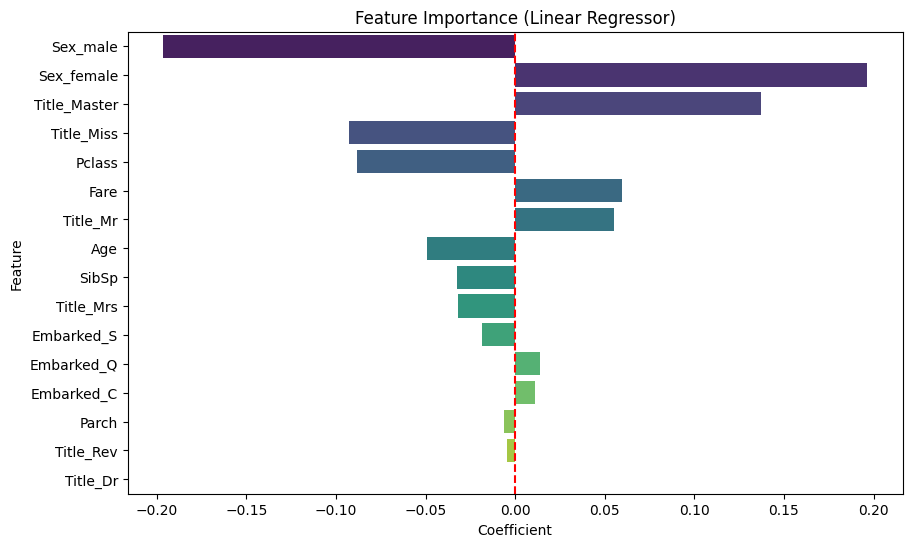

In [72]:
importance = pd.DataFrame({
    'Feature': X_linear_train.columns,
    'Coefficient': lr.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (Linear Regressor)')
plt.show()

### 5.2 Linear Regression (GD)


/tmp/ipython-input-1407387304.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


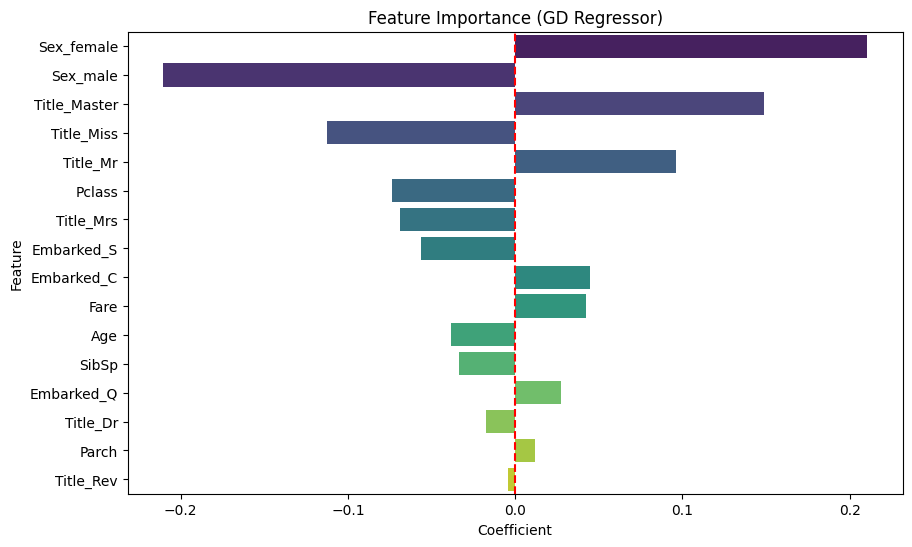

In [73]:
importance = pd.DataFrame({
    'Feature': X_linear_train.columns,
    'Coefficient': lr_gd.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (GD Regressor)')
plt.show()

### 5.3 Linear Regression (SGD)


/tmp/ipython-input-1103185770.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


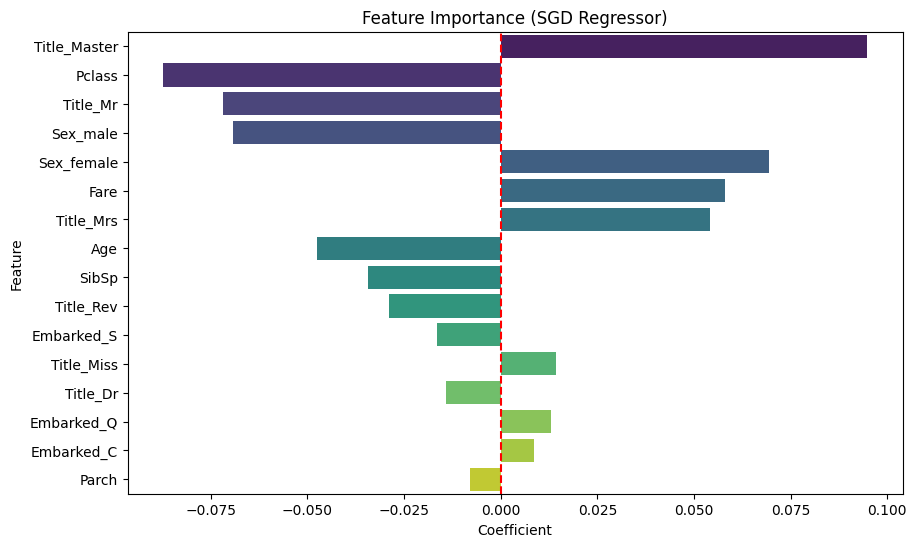

In [74]:
importance = pd.DataFrame({
    'Feature': X_linear_train.columns,
    'Coefficient': lr_sgd.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (SGD Regressor)')
plt.show()

### 5.4 Linear Regression (Rigde)


/tmp/ipython-input-1776803165.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


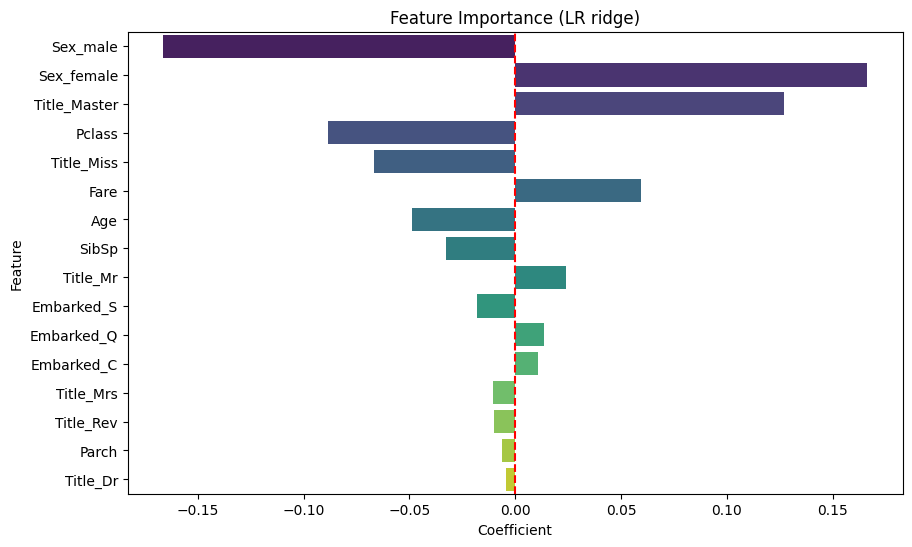

In [75]:
importance = pd.DataFrame({
    'Feature': X_linear_train.columns,
    'Coefficient': lr_ridge.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (LR ridge)')
plt.show()

### 5.5 Linear Regression (Lasso)


/tmp/ipython-input-2795070993.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


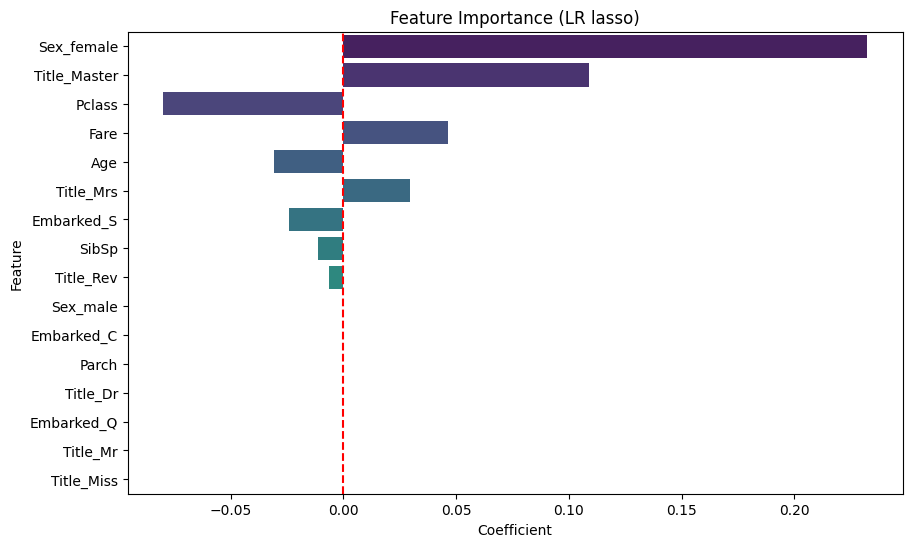

In [76]:
importance = pd.DataFrame({
    'Feature': X_linear_train.columns,
    'Coefficient': lr_lasso.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (LR lasso)')
plt.show()

### 5.6 Linear Regression (ElasticNet)


/tmp/ipython-input-3141820843.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


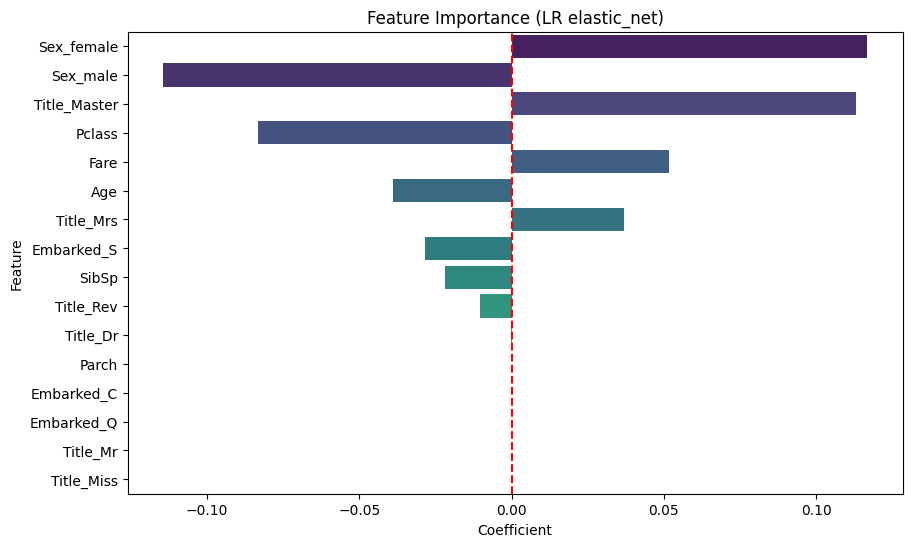

In [77]:
importance = pd.DataFrame({
    'Feature': X_linear_train.columns,
    'Coefficient': lr_enet.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (LR elastic_net)')
plt.show()

### 5.7 Random Forest


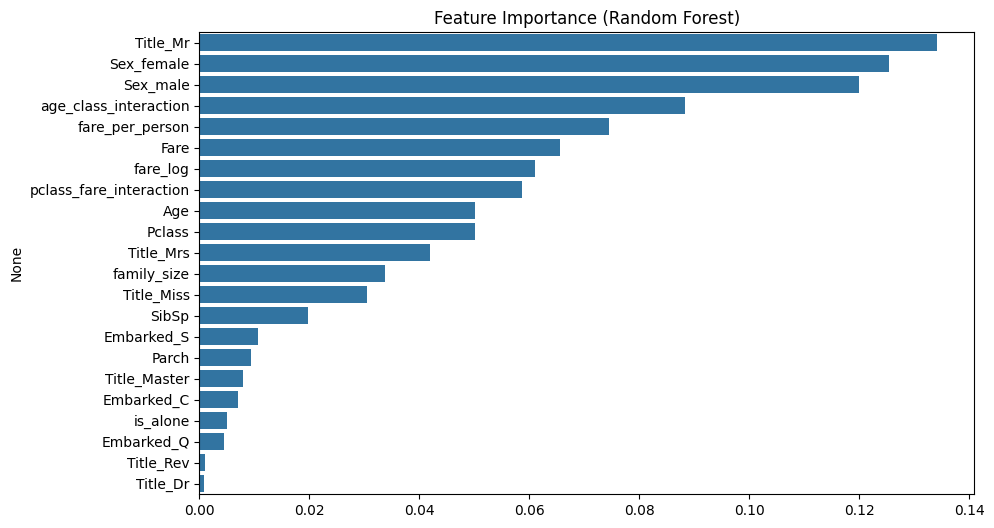

In [78]:
feature_importances = pd.Series(rf.feature_importances_, index=X_forest.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title("Feature Importance (Random Forest)")
plt.show()

### 5.6 XGBoost

<Figure size 1000x600 with 0 Axes>

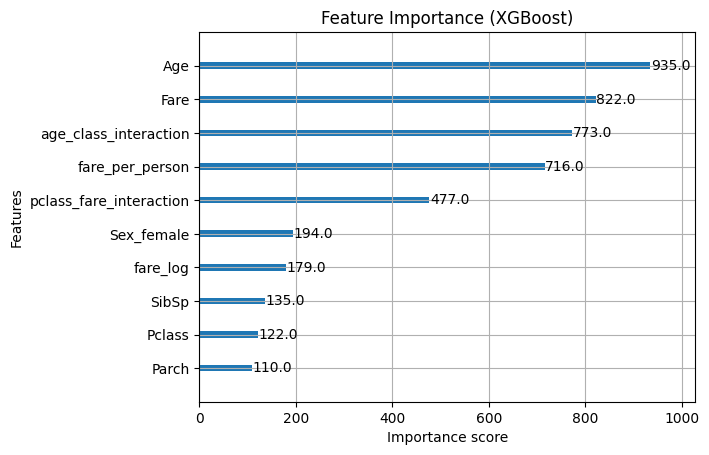

In [79]:
plt.figure(figsize=(10,6))
xgboost.plot_importance(xgb, importance_type='weight', max_num_features=10)
plt.title("Feature Importance (XGBoost)")
plt.show()

## 8. Написание своих реализаций (классы)

Напишите свои классы реализации:

- LR (Линейная регрессия)
- LR + GD (+ Градиентный спуск)
- LR + SGD (+ Стохастический градиентный спуск)
- *Random Forest (не обязательно)
- *Gradient Boosting Regressor (не обязательно)

In [80]:
from typing import Optional, Any

In [81]:
class LinearRegression:
    def __init__(
            self,
            fit_intercept: bool = True,
            normalize: bool = False,
            random_state: Optional[int] = None
    ) -> None:
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.random_state = random_state
        self.coef_: Optional[np.ndarray] = None
        self.intercept_: float = 0.0
        self._X_mean: Optional[np.ndarray] = None
        self._X_std: Optional[np.ndarray] = None


    def _validate_inputs(
            self,
            X: np.ndarray,
            y: Optional[np.ndarray] = None
    ) -> tuple[np.ndarray, Optional[np.ndarray]]:
        X = np.asarray(X, dtype=float)
        if X.ndim != 2:
            raise ValueError("X must be 2D array (n_samples, n_features)")
        if X.shape[0] == 0:
            raise ValueError("X must contain at least one sample")
        if y is not None:
            y = np.asarray(y, dtype=float).reshape(-1)
            if y.shape[0] != X.shape[0]:
                raise ValueError("X and y have incompatible first dimension")
        return X, y

    def _standardize(
            self,
            X: np.ndarray,
            fit: bool = False
    ) -> np.ndarray:
        if not self.normalize:
            return X
        if X.size == 0 or X.shape[0] == 0:
            raise ValueError("Cannot standardize empty array")
        if fit:
            n_samples = X.shape[0]
            if n_samples == 0:
                raise ValueError("Cannot compute mean/std on empty array")
            self._X_mean = X.mean(axis=0)
            self._X_std = X.std(axis=0, ddof=0)
            self._X_std = np.where(self._X_std == 0.0, 1.0, self._X_std)
        if self._X_mean is None or self._X_std is None:
            raise RuntimeError("Normalization statistics are not initialized")
        return (X - self._X_mean) / self._X_std

    def _add_intercept(
            self,
            X: np.ndarray
    ) -> np.ndarray:
        if not self.fit_intercept:
            return X
        ones = np.ones((X.shape[0], 1), dtype=float)
        return np.hstack([ones, X])

    def _design_matrix(
            self,
            X: np.ndarray,
            fit: bool = False
    ) -> np.ndarray:
        X = np.asarray(X, dtype=float)
        if X.ndim == 1:
            X = X.reshape(1, -1)
        if self.normalize:
            X = self._standardize(X, fit=fit)
        return self._add_intercept(X)

    def _init_weights(
            self,
            dim: int
    ) -> np.ndarray:
        rng = np.random.default_rng(self.random_state)
        return rng.standard_normal(dim) * 1e-2

    def _compute_loss(
            self,
            X_design: np.ndarray,
            y: np.ndarray,
            w: np.ndarray
    ) -> float:
        resid = X_design @ w - y
        return float(np.mean(resid ** 2))

    def _fit_analytic(
            self,
            X: np.ndarray,
            y: np.ndarray
    ) -> None:
        Xd = self._design_matrix(X, fit=True)
        if Xd.size == 0:
            raise ValueError("Design matrix is empty")

        try:
            w = np.linalg.pinv(Xd) @ y
        except np.linalg.LinAlgError:
            w = np.linalg.lstsq(Xd, y, rcond=None)[0]

        if self.fit_intercept:
            self.intercept_ = float(w[0])
            self.coef_ = np.asarray(w[1:], dtype=float)
        else:
            self.intercept_ = 0.0
            self.coef_ = np.asarray(w, dtype=float)

    def _fit_gd_wrapper(self, X, y, lr, n_iter, tol, verbose, return_history):
        Xd = self._design_matrix(X, fit=True)
        n_samples, d = Xd.shape
        w = self._init_weights(d)
        loss_history: List[float] = []

        for it in range(n_iter):
            preds = Xd @ w
            resid = preds - y
            loss = float(np.mean(resid ** 2))
            loss_history.append(loss)

            grad = (2.0 / n_samples) * (Xd.T @ resid)
            w_new = w - lr * grad

            if np.linalg.norm(w_new - w) < tol:
                w = w_new
                if verbose:
                    print(f"Converged at iteration {it}")
                break
            w = w_new

            if verbose and it % 100 == 0:
                print(f"Iteration {it}, Loss: {loss:.6f}")

        if self.fit_intercept:
            self.intercept_ = float(w[0])
            self.coef_ = np.asarray(w[1:], dtype=float)
        else:
            self.intercept_ = 0.0
            self.coef_ = np.asarray(w, dtype=float)

        return {"loss_history": loss_history} if return_history else self

    def _fit_sgd_wrapper(self, X, y, lr, n_iter, batch_size, shuffle, verbose, return_history):
        Xd = self._design_matrix(X, fit=True)
        n_samples, d = Xd.shape

        w = self._init_weights(d)
        loss_history: List[float] = []

        if batch_size is None or batch_size <= 0:
            batch_size = 1
        batch_size = int(batch_size)

        for epoch in range(n_iter):
            indices = np.arange(n_samples)
            if shuffle:
                rng = np.random.default_rng(self.random_state)
                rng.shuffle(indices)

            epoch_loss = 0.0
            batch_count = 0

            for start in range(0, n_samples, batch_size):
                end = min(start + batch_size, n_samples)
                batch_indices = indices[start:end]

                X_batch = X[batch_indices]
                y_batch = y[batch_indices]
                Xb_design = self._design_matrix(X_batch, fit=False)

                preds = Xb_design @ w
                resid = preds - y_batch
                batch_loss = np.mean(resid ** 2)
                epoch_loss += batch_loss
                batch_count += 1

                grad = (2.0 / Xb_design.shape[0]) * (Xb_design.T @ resid)
                w = w - lr * grad

            avg_epoch_loss = epoch_loss / batch_count if batch_count > 0 else 0.0
            loss_history.append(avg_epoch_loss)

            if verbose and epoch % 100 == 0:
                print(f"Epoch {epoch}, Average Loss: {avg_epoch_loss:.6f}")

        if self.fit_intercept:
            self.intercept_ = float(w[0])
            self.coef_ = np.asarray(w[1:], dtype=float)
        else:
            self.intercept_ = 0.0
            self.coef_ = np.asarray(w, dtype=float)

        return {"loss_history": loss_history} if return_history else self

    def fit(
            self,
            X: np.ndarray,
            y: np.ndarray,
            method: str = "analytic",
            lr: float = 1e-2,
            n_iter: int = 1000,
            tol: float = 1e-6,
            batch_size: Optional[int] = None,
            verbose: bool = False,
            return_history: bool = False,
            **sgd_kwargs
    ) -> Any:
        X, y = self._validate_inputs(X, y)
        method = method.lower()

        if method == "analytic":
            self._fit_analytic(X, y)
            return {"loss_history": None} if return_history else self
        elif method == "gd":
            return self._fit_gd_wrapper(X, y, lr, n_iter, tol, verbose, return_history)
        elif method == "sgd":
            shuffle = sgd_kwargs.get("shuffle", True)
            return self._fit_sgd_wrapper(X, y, lr, n_iter, batch_size, shuffle, verbose, return_history)
        else:
            raise ValueError("Unknown method. Choose 'analytic', 'gd' or 'sgd'.")

    def predict(self, X: np.ndarray) -> np.ndarray:
        X = np.asarray(X, dtype=float)
        if self.coef_ is None:
            raise ValueError("Model is not fitted")
        if X.ndim == 1:
            X = X.reshape(1, -1)

        Xd = self._design_matrix(X, fit=False)

        if self.fit_intercept:
            if Xd.shape[1] != len(self.coef_) + 1:
                raise ValueError(f"Feature dimension mismatch: expected {len(self.coef_) + 1}, got {Xd.shape[1]}")
            w = np.concatenate([[self.intercept_], self.coef_])
        else:
            if Xd.shape[1] != len(self.coef_):
                raise ValueError(f"Feature dimension mismatch: expected {len(self.coef_)}, got {Xd.shape[1]}")
            w = self.coef_

        return Xd @ w

    def mse(self, X: np.ndarray, y: np.ndarray) -> float:
        preds = self.predict(X)
        return float(np.mean((preds - y) ** 2))

    def rmse(self, X: np.ndarray, y: np.ndarray) -> float:
        return float(np.sqrt(self.mse(X, y)))

    def mae(self, X: np.ndarray, y: np.ndarray) -> float:
        preds = self.predict(X)
        return float(np.mean(np.abs(preds - y)))

    def r2_score(self, X: np.ndarray, y: np.ndarray) -> float:
        preds = self.predict(X)
        ss_res = np.sum((y - preds) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        return float(1.0 - ss_res / ss_tot) if ss_tot != 0.0 else 0.0

    def get_params(self) -> dict[str, Any]:
        return {"coef": self.coef_, "intercept": self.intercept_}

In [82]:
X_train = X_linear_train.values
y_train = y_linear_train.values
X_test = X_linear_test.values
y_test = y_linear_test.values

model_analytic = LinearRegression(fit_intercept=True, normalize=True)
model_analytic.fit(X_train, y_train, method="analytic")
print("=== Аналитический метод ===")
print("Коэффициенты:", model_analytic.coef_)
print("Свободный член:", model_analytic.intercept_)
print("R² (train):", model_analytic.r2_score(X_train, y_train))
print("R² (test):", model_analytic.r2_score(X_test, y_test))
print("MSE (test):", model_analytic.mse(X_test, y_test))
print("RMSE (test):", model_analytic.rmse(X_test, y_test))
print()

metrics_df = pd.concat([metrics_df, pd.DataFrame([{'Model': 'Linear Regression (Analytic - Custom)',
                                                 'MSE': model_analytic.mse(X_test, y_test),
                                                 'RMSE': model_analytic.rmse(X_test, y_test),
                                                 'MAE': model_analytic.mae(X_test, y_test),
                                                 'R2': model_analytic.r2_score(X_test, y_test)}])], ignore_index=True)


model_gd = LinearRegression(fit_intercept=True, normalize=True, random_state=RND_SEED)
model_gd.fit(X_train, y_train, method="gd", lr=1e-3, n_iter=5000, verbose=False)
print("=== Градиентный спуск ===")
print("Коэффициенты:", model_gd.coef_)
print("Свободный член:", model_gd.intercept_)
print("R² (train):", model_gd.r2_score(X_train, y_train))
print("R² (test):", model_gd.r2_score(X_test, y_test))
print("MSE (test):", model_gd.mse(X_test, y_test))
print("RMSE (test):", model_gd.rmse(X_test, y_test))
print()

metrics_df = pd.concat([metrics_df, pd.DataFrame([{'Model': 'Linear Regression (GD - Custom)',
                                                 'MSE': model_gd.mse(X_test, y_test),
                                                 'RMSE': model_gd.rmse(X_test, y_test),
                                                 'MAE': model_gd.mae(X_test, y_test),
                                                 'R2': model_gd.r2_score(X_test, y_test)}])], ignore_index=True)


model_sgd = LinearRegression(fit_intercept=True, normalize=True, random_state=RND_SEED)
history = model_sgd.fit(X_train, y_train, method="sgd", lr=1e-2, n_iter=200,
                        batch_size=32, shuffle=True, return_history=True)
print("=== SGD ===")
print("Коэффициенты:", model_sgd.coef_)
print("Свободный член:", model_sgd.intercept_)
print("R² (train):", model_sgd.r2_score(X_train, y_train))
print("R² (test):", model_sgd.r2_score(X_test, y_test))
print("MSE (test):", model_sgd.mse(X_test, y_test))
print("RMSE (test):", model_sgd.rmse(X_test, y_test))

metrics_df = pd.concat([metrics_df, pd.DataFrame([{'Model': 'Linear Regression (SGD - Custom)',
                                                 'MSE': model_sgd.mse(X_test, y_test),
                                                 'RMSE': model_sgd.rmse(X_test, y_test),
                                                 'MAE': model_sgd.mae(X_test, y_test),
                                                 'R2': model_sgd.r2_score(X_test, y_test)}])], ignore_index=True)



=== Аналитический метод ===
Коэффициенты: [-8.85068997e-02 -4.89308279e-02 -3.25239427e-02 -6.24220292e-03
  5.95965744e-02  1.96602250e-01 -1.96602250e-01  1.08304624e-02
  1.38794234e-02 -1.83993714e-02  4.80582502e-05  1.37094839e-01
 -9.26517936e-02  5.49770850e-02 -3.21586746e-02 -4.42030094e-03]
Свободный член: 0.371980676328503
R² (train): 0.4577353881681264
R² (test): 0.40613281145675273
MSE (test): 0.144013858961363
RMSE (test): 0.3794915795658225



/tmp/ipython-input-1876937337.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame([{'Model': 'Linear Regression (Analytic - Custom)',


=== Градиентный спуск ===
Коэффициенты: [-0.08878543 -0.04787316 -0.03285741 -0.00616715  0.05891052  0.06617404
 -0.08503177  0.01427236  0.01623    -0.01351628 -0.01605847  0.09880682
  0.01413438 -0.06537443  0.05754995 -0.02704333]
Свободный член: 0.37196411795257794
R² (train): 0.4561864932161299
R² (test): 0.4083227264490128
MSE (test): 0.1434828006457717
RMSE (test): 0.3787912362314784

=== SGD ===
Коэффициенты: [-0.0905702  -0.05459104 -0.02676574 -0.0113681   0.05925341  0.10612728
 -0.12498501  0.01004914  0.01478829 -0.0089424  -0.00837505  0.10910529
 -0.01205214 -0.0270362   0.02388722 -0.0189582 ]
Свободный член: 0.37444210072909595
R² (train): 0.4558180201516935
R² (test): 0.4045325774813313
MSE (test): 0.1444019185721437
RMSE (test): 0.380002524428646


## 9. Итоги

Что сделать?

1. Сгрупировать все метрики, и выяснить, какой методо сработал лучше всего и почему?
2. Ответить на вопросы:

    1. Что такое регрессия и чем она отличается от классификации?
    2. Какова целевая переменная в задаче регрессии?
    3. Зачем нужно масштабирование признаков перед обучением линейной регрессии?
    4. Что означает коэффициент признака в линейной регрессии?
    5. Что такое MSE, RMSE, MAE и R², и чем они отличаются?
    6. В чем разница между Ridge и Lasso регуляризацией?
    7. Почему деревья решений и Random Forest не требуют стандартизации признаков?
    8. Что такое мультиколлинеарность и почему она мешает линейной регрессии?
    9. Как можно уменьшить влияние выбросов на линейную регрессию?
    10. Какие гиперпараметры наиболее важны для Random Forest Regressor?
    11. Какие гиперпараметры наиболее важны для XGBoost в задаче регрессии?
    12. Что значит глубина дерева (max\_depth) и как она влияет на модель?
    13. Зачем нужен `learning_rate` в градиентном бустинге?
    14. Как можно оценить важность признаков (feature importance) в линейной регрессии, случайном лесу и XGBoost?
    15. Почему XGBoost часто работает лучше, чем Random Forest, на структурированных данных?
    16. Что такое переобучение и как его можно выявить на графике обучения?
    17. Как работает метод ансамблирования в Random Forest (bagging)?
    18. В чем отличие бустинга от бэггинга?
    19. Какие способы feature engineering можно применить к данному датасету (titanic-dataset)?
    20. Как использовать кросс-валидацию для подбора гиперпараметров моделей регрессии?


#### 9.1. Группировка метрик

In [83]:
metrics_df = pd.concat([metrics_df, pd.DataFrame([{**{'Model': 'Linear Regression (Analytic)'}, **lr_metrics}])], ignore_index=True)
metrics_df = pd.concat([metrics_df, pd.DataFrame([{**{'Model': 'Linear Regression (GD)'}, **lr_gd_metrics}])], ignore_index=True)
metrics_df = pd.concat([metrics_df, pd.DataFrame([{**{'Model': 'Linear Regression (SGD)'}, **lr_sgd_metrics}])], ignore_index=True)
metrics_df = pd.concat([metrics_df, pd.DataFrame([{**{'Model': 'Linear Regression (Ridge)'}, **lr_ridge_metrics}])], ignore_index=True)
metrics_df = pd.concat([metrics_df, pd.DataFrame([{**{'Model': 'Linear Regression (Lasso)'}, **lr_lasso_metrics}])], ignore_index=True)
metrics_df = pd.concat([metrics_df, pd.DataFrame([{**{'Model': 'Linear Regression (ElasticNet)'}, **lr_enet_metrics}])], ignore_index=True)
metrics_df = pd.concat([metrics_df, pd.DataFrame([{**{'Model': 'Random Forest Regressor'}, **rf_metrics}])], ignore_index=True)
metrics_df = pd.concat([metrics_df, pd.DataFrame([{**{'Model': 'XGBoost'}, **xgb_metrics}])], ignore_index=True)

display(metrics_df.drop(columns=['R²']))

,Model,MSE,RMSE,MAE,R2
0,Linear Regression (Analytic - Custom),0.144014,0.379492,0.283746,0.406133
1,Linear Regression (GD - Custom),0.143483,0.378791,0.283068,0.408323
2,Linear Regression (SGD - Custom),0.144402,0.380003,0.283648,0.404533
3,Linear Regression (Analytic),0.144014,0.379492,0.283746,0.406133
4,Linear Regression (GD),0.155443,0.394262,0.315132,0.359004
5,Linear Regression (SGD),0.141109,0.375645,0.284686,0.418111
6,Linear Regression (Ridge),0.143824,0.379241,0.283536,0.406916
7,Linear Regression (Lasso),0.146079,0.382203,0.287791,0.397618
8,Linear Regression (ElasticNet),0.143950,0.379408,0.283936,0.406394
9,Random Forest Regressor,0.124025,0.352172,0.255110,0.488559


#### 9.2. Ответы на вопросы

1. Что такое регрессия и чем она отличается от классификации?
Цель регрессии - прогнозирование числовых значений, классификация дает ответ в виде меток классов.

2. Какова целевая переменная в задаче регрессии?
Непрерывное число, которое хотим предсказать.

3. Зачем нужно масштабирование признаков перед обучением линейной регрессии?
Чтобы все объекты вносили одинаковый вклад в модель.

4. Что означает коэффициент признака в линейной регрессии?
Показывает силу и характер влияния независимых переменных на зависимую и характеризуют степень значимости отдельных переменных для повышения точности модели.

5. Что такое MSE, RMSE, MAE и R², и чем они отличаются?
- **MSE (Mean Squared Error)** – средняя квадратичная ошибка
- **RMSE (Root Mean Squared Error)** – корень из MSE
- **MAE (Mean Absolute Error)** – средняя абсолютная ошибка  
- **R² (коэффициент детерминации)** – объясняет вариацию данных

MSE показывает среднюю квадратичную ошибку. RMSE в тех же единицах, что и цель, удобно для прямой интерпретации. Если RMSE и MAE сильно отличаются - есть выбросы. MAE устойчивее к выбросам, показывает среднюю фактическую ошибку. R²: 1 — идеальное совпадение, 0 — предсказывает среднее, <0 — хуже среднего

6. В чем разница между Ridge и Lasso регуляризацией?
Лассо зануляет коэффициенты. То есть буквально перед какими-то признаками она ставит 0 и в модели они не рассматриваются. Ридж же может коэффициент сильно уменьшить, но не занулить

7. Почему деревья решений и Random Forest не требуют стандартизации признаков?
Древовидные алгоритмы нечувствительны к масштабу данных. Эти алгоритмы разделяют данные на основе пороговых значений признаков, поэтому стандартизация признаков не повлияет на их производительность

8. Что такое мультиколлинеарность и почему она мешает линейной регрессии?
Мультиколлинеарность — это явление, при котором одна из входных переменных статистической модели линейно зависит от других входных переменных, т.е. между ними наблюдается сильная корреляция. В этой ситуации оценки коэффициентов модели могут случайно и значительно изменяться даже при небольших изменениях в исходных данных, т.е. решение становится неустойчивым.

9. Как можно уменьшить влияние выбросов на линейную регрессию?
Удаление выбросов; масштабирование.

10. Какие гиперпараметры наиболее важны для Random Forest Regressor?
Количество деревьев (n_estimators), максимальную глубину каждого дерева (max_depth), минимальное количество образцов, необходимое для разделения узла (min_samples_leaf, min_samples_split), и количество признаков, которые следует учитывать при каждом разделении (max_features).

11. Какие гиперпараметры наиболее важны для XGBoost в задаче регрессии?
max_depth, min_child_weight (минимальная сумма весов экземпляров, необходимая для потомка), subsample (коэффициент подвыборки обучающих данных), colsample_bytree (коэффициент подвыборки столбцов при построении каждого дерева), learning_rate (уменьшение размера шага, используемое для предотвращения переобучения).

12. Что значит глубина дерева (max_depth) и как она влияет на модель?
Ограничивает глубину каждого дерева, предотвращая переобучение13. Зачем нужен learning_rate в градиентном бустинге?
Насколько сильный вклад добавляет каждое новое дерево. Маленький lr обучение медленнее, но аккуратнее, нужно больше деревьев. Слишком большой lr быстро, но легко переобучиться.

14. Как можно оценить важность признаков (feature importance) в линейной регрессии, случайном лесу и XGBoost?
По коэффициентам; SHAP; ExhaustiveFeatureSelector.

15. Почему XGBoost часто работает лучше, чем Random Forest, на структурированных данных?
Boosting представляет собой итеративное обучение. Поэтому есть уверенность, что прогноз произошел не случайно, а с глубоким пониманием и выявлением закономерностей в данных.

В случайном лесе собираем выходные данные всех деревьев и рассматриваем среднее значение, медиану или моду этого набора в качестве прогноза. Но каждое дерево может содержать дисбаланс классов, дублирование выборок, переобучение, неправильное разделение узлов.

16. Что такое переобучение и как его можно выявить на графике обучения?
Это ситуация, когда модель слишком точно подстраивается под обучающую выборку. Такая модель показывает высокую точность на уже знакомых данных, но плохо работает на новых.

По графику обучения на новых данных сначала убывает (модель учится), но после определённой точки начинает расти.

17. Как работает метод ансамблирования в Random Forest (bagging)?
Для каждого n = 1, ..., N:
- Сгенерировать выборку X_n с помощью бутстрэпа;
- Построить решающее дерево b_n по выборке X_n:
  - по заданному критерию мы выбираем лучший признак, делаем разбиение в дереве по нему и так до исчерпания выборки
  - дерево строится, пока в каждом листе не более n_min объектов или пока не достигнем определенной высоты дерева
  - при каждом разбиении сначала выбирается m случайных признаков из n исходных, и оптимальное разделение выборки ищется только среди них.

Итоговое значение a(x) = (1/N)∑b_i(x)

18. В чем отличие бустинга от бэггинга?
Бустинг итеративный, бэггинг параллельный.

19. Какие способы feature engineering можно применить к винному датасету (Wine Quality)?
Отбор признаков по корреляции, стандартизация признаков.

20. Как использовать кросс-валидацию для подбора гиперпараметров моделей регрессии?
Разбить данные на обучающие и тестовые. Выбрать метод. Указать гиперпараметры и диапазон значений. Сделать оценку на тестовых данных.